<a href="https://colab.research.google.com/github/pedrobslima/CNN_comparison/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Análise comparativa de redes para segmentação semântica
Por:

* Pedro Barros de Souza Lima (pbsl@cin.ufpe.br)
* Gabriel Henrique Vasconcelos (ghv@cin.ufpe.br)

---



## Imports and unzip
(run without fear)

In [ ]:
!pip install torchmetrics

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchmetrics
from torchmetrics.classification import BinaryJaccardIndex
from torchmetrics.classification import BinaryAccuracy
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F
from numba import cuda as c
import os
import random

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 92.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
!unzip Dataset_BUSI_with_GT.zip

Archive:  Dataset_BUSI_with_GT.zip
   creating: Dataset_BUSI_with_GT/benign/
  inflating: Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (104).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (104)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (105).

In [ ]:
!unzip redes.zip

## Dataset creation & management
(ok to run | creates dataset/dataloader)

In [ ]:
def string_path(tp: str, idx: int) -> tuple:
  base_path = f'/content/Dataset_BUSI_with_GT/{tp}/{tp} ({idx}).png'
  mask_path = f'/content/Dataset_BUSI_with_GT/{tp}/{tp} ({idx})_mask.png'
  return (base_path, mask_path)

In [ ]:
class ImgDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        self.transform = transforms.Compose([
          # talvez devesse cortar como o livro sugere, mas tem segmentações grandes demais pra qualquer tipo de corte, ent vou dxar assim por enquanto
          transforms.Resize([256, 256]), # O melhor seria 512x512 por ser o mais perto da média de tam, mas a GPU não aguenta quando vai pro fastfcn
          transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]['image_path']
        mask_path = self.data.iloc[idx]['mask_path']

        image = Image.open(image_path).convert('L')
        mask = Image.open(mask_path).convert('L')

        return self.transform(image), self.transform(mask)

In [ ]:
imgs = [string_path('benign', i) for i in range(1, 438)]
imgs = imgs + [string_path('malignant', i) for i in range(1, 211)]
#imgs = imgs + [string_path('normal', i) for i in range(1, 134)]

df = pd.DataFrame(imgs, columns=['image_path', 'mask_path'])

df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True)

train_dataset = ImgDataset(df_train)
test_dataset = ImgDataset(df_test)

BATCH_SIZE = 8
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Models

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
NUM_EPOCHS = 40

### utils

(run without fear)

Funções para plotagem de previsões dos modelos:

In [ ]:
def threshold_prediction(predicted, threshold=0.5):
    # Threshold predicted values
    predicted[predicted < threshold] = 0
    predicted[predicted >= threshold] = 1
    return predicted

def to_np(tensor):
    # Move tensor to CPU and convert to NumPy array
    return tensor.cpu().detach().numpy()

def plot_subplots(image, mask, predicted, threshold=0.5):
    # Convert tensors to NumPy arrays
    image_np, mask_np, predicted_np = map(to_np, (image, mask, predicted))

    # Threshold the predicted values
    predicted_np_thresholded = threshold_prediction(predicted_np, threshold)

    fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # Adjust figsize as needed

    # Plot Image, Mask, Predicted, and Thresholded Predicted
    titles = ['Image', 'Mask', 'Predicted']
    for ax, data, title in zip(axes, [image_np, mask_np, predicted_np, predicted_np_thresholded], titles):
        ax.imshow(data.squeeze(), cmap='gray' if 'Mask' in title else 'gray')
        ax.set_title(title)
        ax.axis('off')

    plt.show()

def plot_examples(netlist: list, numbers: list=None):
  global test_dataset
  if not numbers:
    numbers = [random.randint(0, len(test_dataset)-1) for _ in range(10)]

  for i in numbers:
    print(i)
    for (name, net) in netlist:
      print(name)
      image = test_dataset[i][0]
      mask = test_dataset[i][1]
      im = image.to(DEVICE)
      pred = net(im.unsqueeze(0))
      pred = pred.squeeze()

      plot_subplots(im, mask, pred)

Função para transformar uma CNN que recebe inputs de 3 canais, em uma que recebe 1 canal, sem a perda dos pesos:

In [ ]:
def nc3tonc1(model):
  mlist = list(model.children())
  conv0wgt = mlist[0].weight
  mlist[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
  mlist[0].weight = nn.Parameter(torch.sum(conv0wgt, dim=1, keepdim=True))
  return nn.Sequential(*mlist)

### Memory management stuff
[don't to run any of it, it's only here in case of memory problems]

(NEVER run all at once, only individually)

Metrics and details

In [ ]:
!nvidia-smi

Sat Mar  9 00:56:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0              28W /  70W |  15059MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 2            |        cudaMalloc retries: 2         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  14802 MiB |  14802 MiB |  29121 MiB |  14319 MiB |
|       from large pool |  14796 MiB |  14796 MiB |  29112 MiB |  14316 MiB |
|       from small pool |      5 MiB |      5 MiB |      9 MiB |      3 MiB |
|---------------------------------------------------------------------------|
| Active memory         |  14802 MiB |  14802 MiB |  29121 MiB |  14319 MiB |
|       from large pool |  14796 MiB |  14796 MiB |  29112 MiB |

### Training classes and Functions

(run without fear)

**Focal Tversky loss function:**

In [ ]:
class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, sig=False):
        super(FocalTverskyLoss, self).__init__()
        self.sig = sig

    def forward(self, inputs, targets, smooth=1, alpha=0.5, beta=0.5, gamma=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        if(self.sig):
          inputs = F.sigmoid(inputs)
          # sig_func = nn.Sigmoid()
          # inputs = sig_func(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()

        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)
        FocalTversky = (1 - Tversky)**gamma

        return FocalTversky

**DiceBCE loss function:**

Uma mistura de duas funções de perda:
* Coeficiente Dice
* Binary Cross Entropy

In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True, sig=False):
        super(DiceBCELoss, self).__init__()
        self.sig = sig

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        if(self.sig):
          inputs = F.sigmoid(inputs)
          # sig_func = nn.Sigmoid()
          # inputs = sig_func(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

**Função de treinamento das CNNs:**

In [ ]:
def train_net(model, tloader, vloader, num_epochs, optimizer, lossFunc):
  train_losses = []
  val_losses = []
  for e in range(num_epochs):
    train_loss = 0.0 # total loss during single epoch training
    val_loss = 0.0
    val_dice = 0.0
    model.train()
    for i, (imgs, masks) in enumerate(tloader):
      imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)

      pred = model(imgs) # predictions based on batch imgs
      loss = lossFunc(pred, masks) # calculates the loss function result(?)
      optimizer.zero_grad() # clears x.grad for every parameter x in the optimizer.
                            # It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.

      loss.backward() # computes dloss/dx for every parameter x which has requires_grad=True. These are accumulated into x.grad for every parameter x
      optimizer.step() # updates the value of x using the gradient x.grad

      l = loss.item()
      train_loss += l # value of loss?
      print(f'Epoch [{e + 1}/{num_epochs}], Step [{i + 1}/{len(tloader)}], Loss: {l:.4f} ')
    model.eval()
    with torch.no_grad():
      for imgs, masks in vloader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        pred = model(imgs)
        l = lossFunc(pred, masks).item()
        val_loss += l
        val_dice += (2 * (pred * masks).sum()) / (2 * (pred * masks).sum()+ ((pred*masks)<1).sum())

      avg_train_loss = train_loss / len(tloader)
      avg_val_loss = val_loss / len(vloader)
      #avg_train_dice = train_dice / len(train_loader)
      avg_val_dice = val_dice / len(vloader)
      print(f'[EVAL TIME] Epoch [{e + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Eval Loss: {avg_val_loss:.4f}, Dice Score = {avg_val_dice:.4f}')
    train_losses.append(avg_train_loss)
    val_losses.append((avg_val_loss, avg_val_dice))
  return train_losses, val_losses

### **Unet**/**ResUnet** class build
(run without fear)

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, input_channel, out_channel, dropout, residual=False):
        super(ConvBlock, self).__init__()
        self.residual = residual
        self.conv1x1 = nn.Conv2d(input_channel, out_channel, kernel_size=1, padding=0)

        self.conv2d_1 = nn.Conv2d(input_channel, out_channel, kernel_size=3, padding=1)
        self.batchnorm_1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(dropout)

        self.conv2d_2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1)
        self.batchnorm_2 = nn.BatchNorm2d(out_channel)
        #self.relu = nn.ReLU()

    def forward(self, x):
        if(self.residual):
          resx = self.conv1x1(x)

        x = self.conv2d_1(x)
        x = self.batchnorm_1(x)
        x = self.relu(x)

        x = self.dropout(x)

        x = self.conv2d_2(x)
        x = self.batchnorm_2(x)

        if(self.residual):
          x = torch.add(x, resx)

        x = self.relu(x)

        return x

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_channel, out_channel, dropout, residual=False):
        super(Encoder, self).__init__()
        self.conv2d_1 = ConvBlock(input_channel, out_channel, dropout, residual)
        self.maxpool = nn.MaxPool2d((2,2))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.conv2d_1(x) # o que vai ser usado pra skip
        xp = self.maxpool(x)
        xp = self.dropout(xp) # o que vai ser passado pra próxima camada

        return xp, x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, input_channel, out_channel, dropout, residual=False):
        super(Decoder, self).__init__()
        self.conv_t = nn.ConvTranspose2d(input_channel, out_channel, stride=2, kernel_size=2)
        self.conv2d_1 = ConvBlock(out_channel*2, out_channel, dropout, residual)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, skip):
        x = self.conv_t(x)
        x = torch.cat([x, skip], dim=1)
        x = self.dropout(x)
        x = self.conv2d_1(x)

        return x

In [ ]:
class Unet(nn.Module):

    def __init__(self, input_channel=1, residual=False):
        super().__init__()
        self.encoder_0 = Encoder(input_channel, 64, 0.07, residual)
        self.encoder_1 = Encoder(64, 128, 0.08, residual)
        self.encoder_2 = Encoder(128, 256, 0.09, residual)
        self.encoder_3 = Encoder(256, 512, 0.1, residual)

        self.conv_block = ConvBlock(512, 1024, 0.11)

        self.decoder_0 = Decoder(1024, 512, 0.1, residual)
        self.decoder_1 = Decoder(512, 256, 0.09, residual)
        self.decoder_2 = Decoder(256, 128, 0.08, residual)
        self.decoder_3 = Decoder(128, 64, 0.07, residual)

        self.cls = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        self.sig = nn.Sigmoid()

    def forward(self, x):

        # Encoder
        x0, skip0 = self.encoder_0(x)   # ------->|
        x1, skip1 = self.encoder_1(x0)  # ----->| |
        x2, skip2 = self.encoder_2(x1)  # --->| | |
        x3, skip3 = self.encoder_3(x2)  # ->| | | |
                                        #   | | | |
        # Bottleneck                        | | | |
        x4 = self.conv_block(x3)        #   | | | |
                                        #   | | | |
        # Decoder                           | | | |
        x5 = self.decoder_0(x4, skip3)  # <-| | | |
        x6 = self.decoder_1(x5, skip2)  # <---| | |
        x7 = self.decoder_2(x6, skip1)  # <-----| |
        x8 = self.decoder_3(x7, skip0)  # <-------|

        # Final (num_channels=1 and sigmoid())
        x_final = self.cls(x8)
        x_final = self.sig(x_final)

        return x_final

### **Unet**

(run for training)

In [ ]:
unet0 = Unet().to(DEVICE)

In [ ]:
# [B, C, H, W] ou [C, H, W]
loss_function = FocalTverskyLoss()
optimizer = optim.Adam(unet0.parameters(), lr=0.001, weight_decay = 1e-6)
tlosses, vlosses = train_net(unet0, train_dataloader, test_dataloader, NUM_EPOCHS, optimizer, loss_function)

Epoch [1/40], Step [1/65], Loss: 0.8597 
Epoch [1/40], Step [2/65], Loss: 0.7346 
Epoch [1/40], Step [3/65], Loss: 0.8056 
Epoch [1/40], Step [4/65], Loss: 0.8733 
Epoch [1/40], Step [5/65], Loss: 0.6821 
Epoch [1/40], Step [6/65], Loss: 0.8331 
Epoch [1/40], Step [7/65], Loss: 0.8030 
Epoch [1/40], Step [8/65], Loss: 0.8068 
Epoch [1/40], Step [9/65], Loss: 0.8446 
Epoch [1/40], Step [10/65], Loss: 0.8153 
Epoch [1/40], Step [11/65], Loss: 0.8642 
Epoch [1/40], Step [12/65], Loss: 0.7741 
Epoch [1/40], Step [13/65], Loss: 0.7216 
Epoch [1/40], Step [14/65], Loss: 0.8953 
Epoch [1/40], Step [15/65], Loss: 0.7147 
Epoch [1/40], Step [16/65], Loss: 0.7822 
Epoch [1/40], Step [17/65], Loss: 0.8256 
Epoch [1/40], Step [18/65], Loss: 0.7399 
Epoch [1/40], Step [19/65], Loss: 0.6593 
Epoch [1/40], Step [20/65], Loss: 0.6427 
Epoch [1/40], Step [21/65], Loss: 0.6508 
Epoch [1/40], Step [22/65], Loss: 0.7109 
Epoch [1/40], Step [23/65], Loss: 0.6514 
Epoch [1/40], Step [24/65], Loss: 0.7197 
E

In [ ]:
unet1 = Unet().to(DEVICE)

In [ ]:
loss_function = DiceBCELoss()
optimizer = optim.Adam(unet1.parameters(), lr=0.001, weight_decay = 1e-6)
tlosses, vlosses = train_net(unet1, train_dataloader, test_dataloader, NUM_EPOCHS, optimizer, loss_function)

Epoch [1/40], Step [1/65], Loss: 1.5209 
Epoch [1/40], Step [2/65], Loss: 1.6544 
Epoch [1/40], Step [3/65], Loss: 1.5325 
Epoch [1/40], Step [4/65], Loss: 1.4584 
Epoch [1/40], Step [5/65], Loss: 1.4690 
Epoch [1/40], Step [6/65], Loss: 1.3632 
Epoch [1/40], Step [7/65], Loss: 1.2875 
Epoch [1/40], Step [8/65], Loss: 1.3562 
Epoch [1/40], Step [9/65], Loss: 1.3895 
Epoch [1/40], Step [10/65], Loss: 1.2973 
Epoch [1/40], Step [11/65], Loss: 1.2655 
Epoch [1/40], Step [12/65], Loss: 1.3014 
Epoch [1/40], Step [13/65], Loss: 1.2451 
Epoch [1/40], Step [14/65], Loss: 1.3377 
Epoch [1/40], Step [15/65], Loss: 1.2326 
Epoch [1/40], Step [16/65], Loss: 1.2882 
Epoch [1/40], Step [17/65], Loss: 1.2330 
Epoch [1/40], Step [18/65], Loss: 1.2689 
Epoch [1/40], Step [19/65], Loss: 1.2569 
Epoch [1/40], Step [20/65], Loss: 1.2200 
Epoch [1/40], Step [21/65], Loss: 1.2172 
Epoch [1/40], Step [22/65], Loss: 1.1892 
Epoch [1/40], Step [23/65], Loss: 1.2036 
Epoch [1/40], Step [24/65], Loss: 1.1784 
E

In [ ]:
torch.save(unet0.state_dict(), '/content/unet_focaltversky.pt')
torch.save(unet1.state_dict(), '/content/unet_dicebce.pt')

### **R-Unet**

In [ ]:
resunet0 = Unet(residual=True).to(DEVICE)

In [ ]:
# [B, C, H, W] ou [C, H, W]
loss_function = FocalTverskyLoss()
optimizer = optim.Adam(resunet0.parameters(), lr=0.001, weight_decay = 1e-6)
tlosses, vlosses = train_net(resunet0, train_dataloader, test_dataloader, NUM_EPOCHS, optimizer, loss_function)

Epoch [1/40], Step [1/65], Loss: 0.8761 
Epoch [1/40], Step [2/65], Loss: 0.7916 
Epoch [1/40], Step [3/65], Loss: 0.8078 
Epoch [1/40], Step [4/65], Loss: 0.5895 
Epoch [1/40], Step [5/65], Loss: 0.7702 
Epoch [1/40], Step [6/65], Loss: 0.6615 
Epoch [1/40], Step [7/65], Loss: 0.8348 
Epoch [1/40], Step [8/65], Loss: 0.6198 
Epoch [1/40], Step [9/65], Loss: 0.8142 
Epoch [1/40], Step [10/65], Loss: 0.7334 
Epoch [1/40], Step [11/65], Loss: 0.8024 
Epoch [1/40], Step [12/65], Loss: 0.8359 
Epoch [1/40], Step [13/65], Loss: 0.6618 
Epoch [1/40], Step [14/65], Loss: 0.7856 
Epoch [1/40], Step [15/65], Loss: 0.7543 
Epoch [1/40], Step [16/65], Loss: 0.5810 
Epoch [1/40], Step [17/65], Loss: 0.6001 
Epoch [1/40], Step [18/65], Loss: 0.7571 
Epoch [1/40], Step [19/65], Loss: 0.7430 
Epoch [1/40], Step [20/65], Loss: 0.7612 
Epoch [1/40], Step [21/65], Loss: 0.8332 
Epoch [1/40], Step [22/65], Loss: 0.5656 
Epoch [1/40], Step [23/65], Loss: 0.7452 
Epoch [1/40], Step [24/65], Loss: 0.6422 
E

In [ ]:
resunet1 = Unet(residual=True).to(DEVICE)

In [ ]:
loss_function = DiceBCELoss()
optimizer = optim.Adam(resunet1.parameters(), lr=0.001, weight_decay = 1e-6)
tlosses, vlosses = train_net(resunet1, train_dataloader, test_dataloader, NUM_EPOCHS, optimizer, loss_function)

Epoch [1/40], Step [1/65], Loss: 1.4574 
Epoch [1/40], Step [2/65], Loss: 1.4322 
Epoch [1/40], Step [3/65], Loss: 1.3066 
Epoch [1/40], Step [4/65], Loss: 1.3625 
Epoch [1/40], Step [5/65], Loss: 1.2270 
Epoch [1/40], Step [6/65], Loss: 1.1941 
Epoch [1/40], Step [7/65], Loss: 1.0812 
Epoch [1/40], Step [8/65], Loss: 1.4120 
Epoch [1/40], Step [9/65], Loss: 1.1552 
Epoch [1/40], Step [10/65], Loss: 1.2226 
Epoch [1/40], Step [11/65], Loss: 1.1480 
Epoch [1/40], Step [12/65], Loss: 1.0982 
Epoch [1/40], Step [13/65], Loss: 1.0681 
Epoch [1/40], Step [14/65], Loss: 1.0612 
Epoch [1/40], Step [15/65], Loss: 1.0907 
Epoch [1/40], Step [16/65], Loss: 1.0578 
Epoch [1/40], Step [17/65], Loss: 0.9891 
Epoch [1/40], Step [18/65], Loss: 0.9430 
Epoch [1/40], Step [19/65], Loss: 0.9458 
Epoch [1/40], Step [20/65], Loss: 1.1103 
Epoch [1/40], Step [21/65], Loss: 1.1271 
Epoch [1/40], Step [22/65], Loss: 0.8828 
Epoch [1/40], Step [23/65], Loss: 0.9269 
Epoch [1/40], Step [24/65], Loss: 0.8442 
E

47
FocalTervsky()


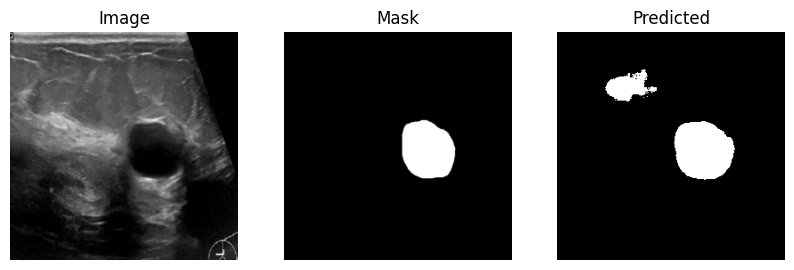

DiceBCELoss()


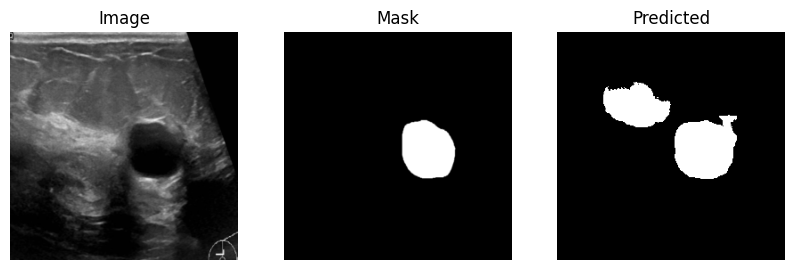

50
FocalTervsky()


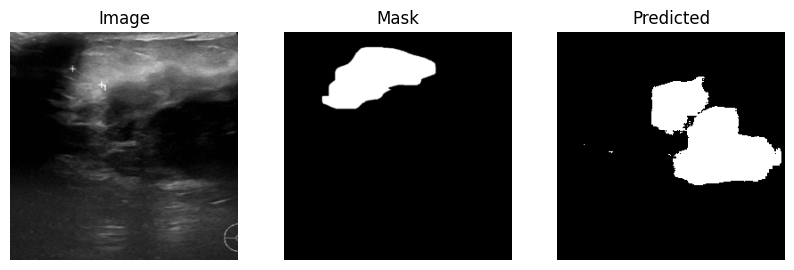

DiceBCELoss()


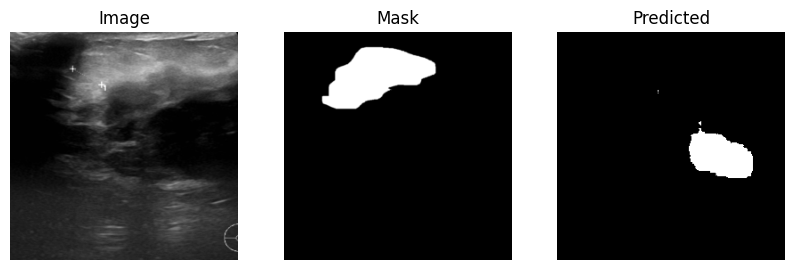

82
FocalTervsky()


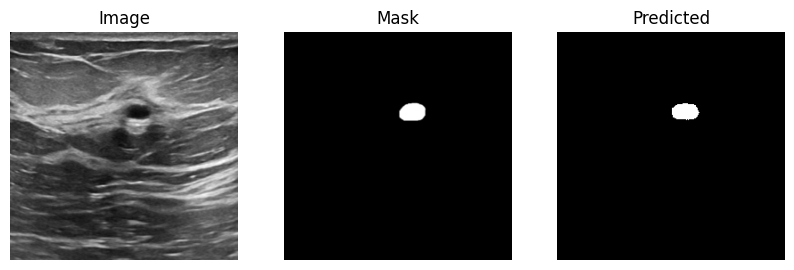

DiceBCELoss()


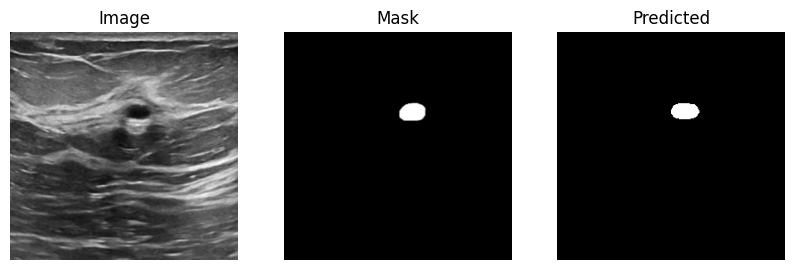

44
FocalTervsky()


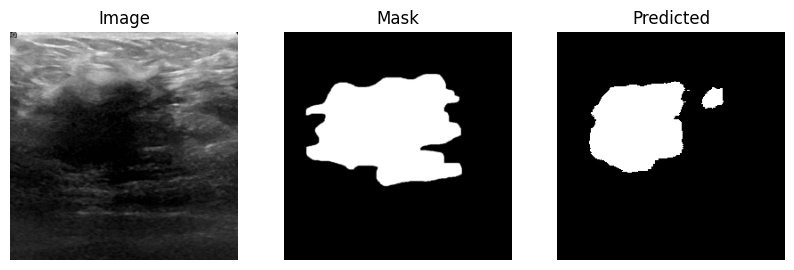

DiceBCELoss()


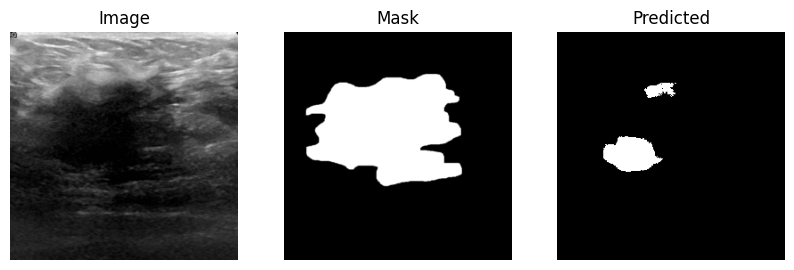

118
FocalTervsky()


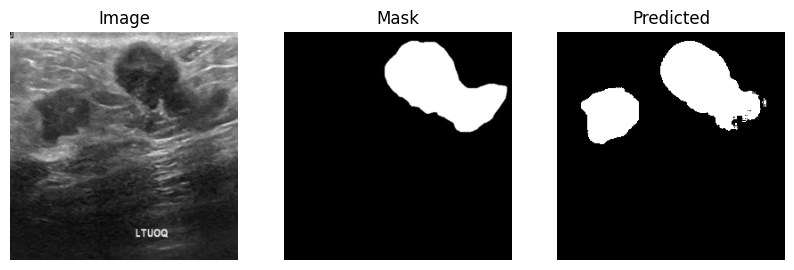

DiceBCELoss()


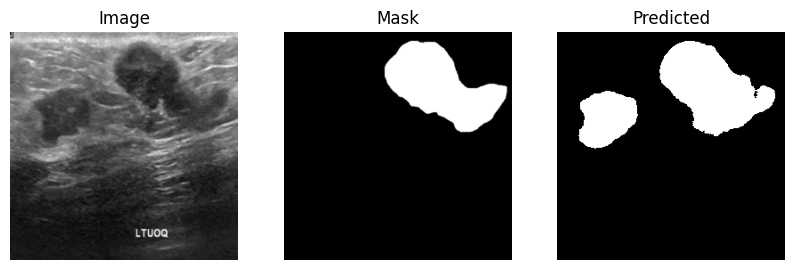

57
FocalTervsky()


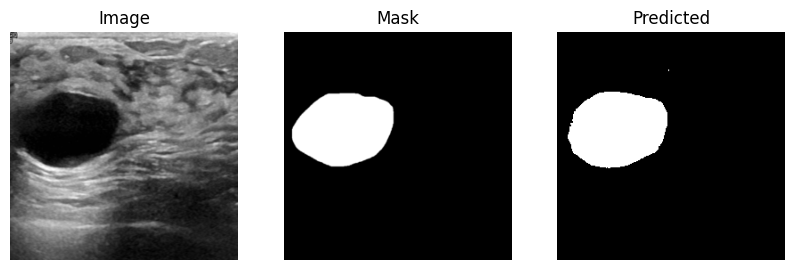

DiceBCELoss()


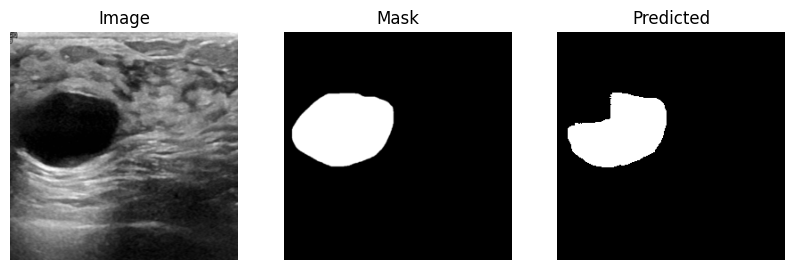

98
FocalTervsky()


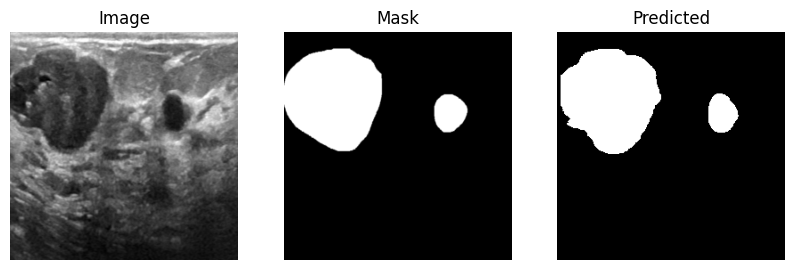

DiceBCELoss()


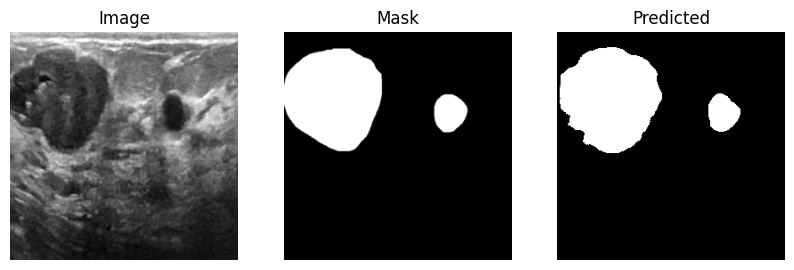

9
FocalTervsky()


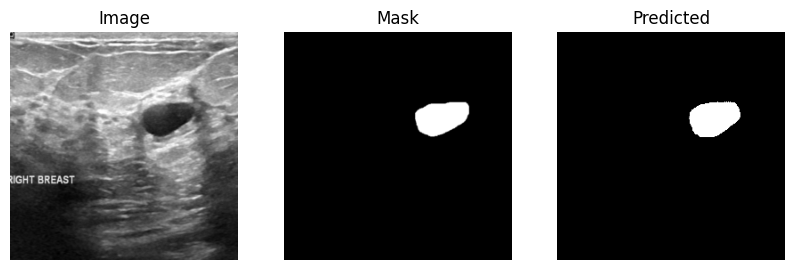

DiceBCELoss()


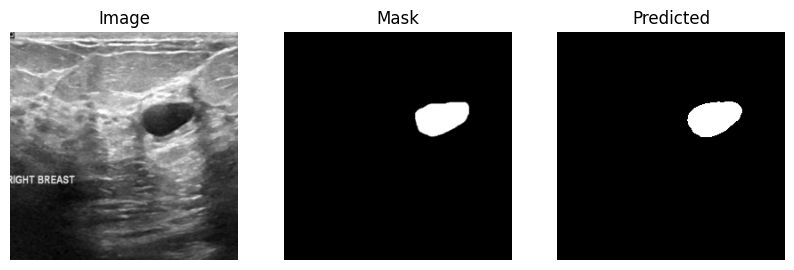

74
FocalTervsky()


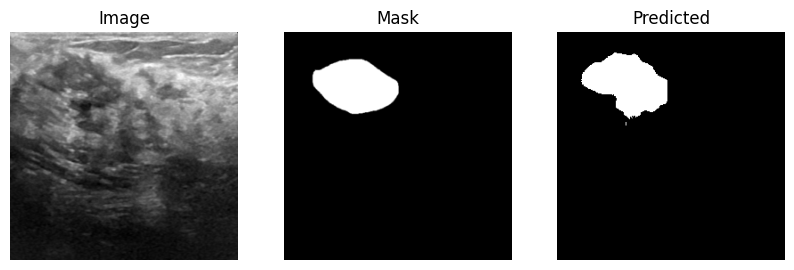

DiceBCELoss()


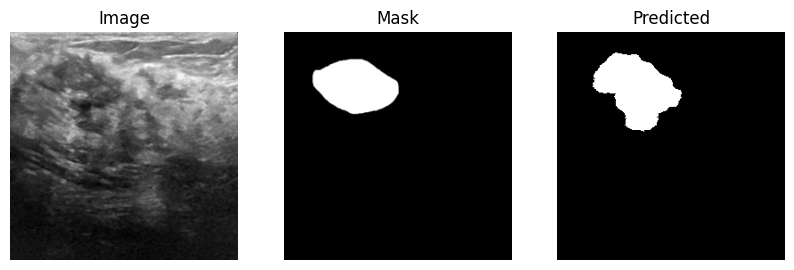

3
FocalTervsky()


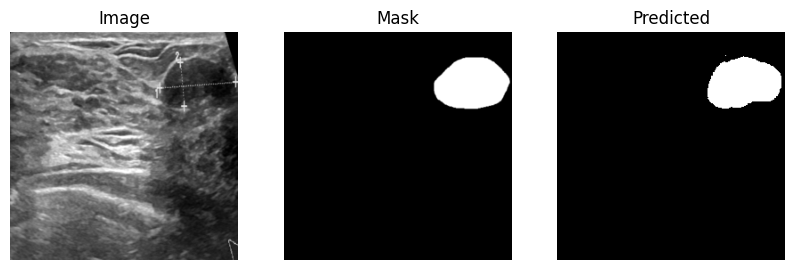

DiceBCELoss()


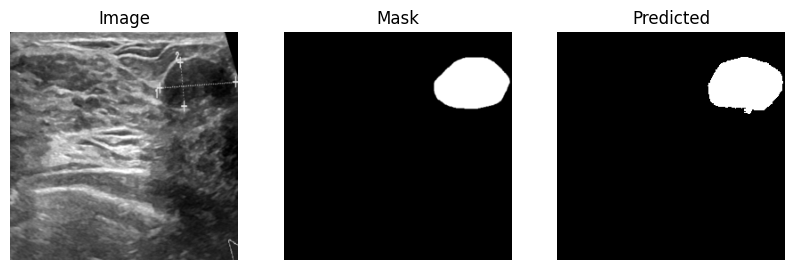

In [ ]:
plot_examples([('FocalTervsky()', resunet0), ('DiceBCELoss()', resunet1)])

In [ ]:
torch.save(resunet0.state_dict(), '/content/resunet_focaltversky.pt')
torch.save(resunet1.state_dict(), '/content/resunet_dicebce.pt')

In [ ]:
torch.save(resunet0.state_dict(), '/content/drive/MyDrive/projeto-dl/resunet_focaltversky.pt')
torch.save(resunet1.state_dict(), '/content/drive/MyDrive/projeto-dl/resunet_dicebce.pt')

### **FastFCN** class build

(run without fear)

In [ ]:
class SeparableConv2d(nn.Module):
    def __init__(self, inplanes, planes, kernel_size=3, stride=1, padding=1, dilation=1, bias=False):
        super(SeparableConv2d, self).__init__()

        self.conv = nn.Conv2d(in_channels=inplanes, out_channels=inplanes,
                               kernel_size=kernel_size, stride=stride,
                               padding=padding, dilation=dilation,
                               groups=inplanes, bias=bias)

        self.bn = nn.BatchNorm2d(inplanes)

        self.pointwise = nn.Conv2d(in_channels=inplanes, out_channels=planes,
                                   kernel_size=1, bias=bias)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.pointwise(x)
        return x

In [ ]:
class JPU(nn.Module):
    """
    Joint Pyramid Upsampling Module proposed in:
    H. Wu et al., FastFCN: Rethinking Dilated Convolution in the Backbone for Semantic Segmentation
    https://arxiv.org/abs/1903.11816
    """

    def __init__(self, in_channels, width=128):
        super(JPU, self).__init__()
        """
        Args:
            in channels: tuple. in ascending order
        """

        # CONVOLUÇÕES
        self.convs = []

        self.conv0 = nn.Sequential(
            nn.Conv2d(in_channels[0], out_channels=width, kernel_size=3,
                      padding=1, bias=False),
            nn.BatchNorm2d(width),
            nn.ReLU(inplace=True)
        )
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels[1], out_channels=width, kernel_size=3,
                      padding=1, bias=False),
            nn.BatchNorm2d(width),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels[2], out_channels=width, kernel_size=3,
                      padding=1, bias=False),
            nn.BatchNorm2d(width),
            nn.ReLU(inplace=True)
        )

        self.convs.append(self.conv0)
        self.convs.append(self.conv1)
        self.convs.append(self.conv2)

        # CONVS WITH DILATIONS
        self.dilation0 = nn.Sequential(
            SeparableConv2d(inplanes=(3 * width), planes=width),
            nn.BatchNorm2d(width),
            nn.ReLU(inplace=True)
        )
        self.dilation1 = nn.Sequential(
            SeparableConv2d(inplanes=(3 * width), planes=width, padding=2, dilation=2),
            nn.BatchNorm2d(width),
            nn.ReLU(inplace=True)
        )
        self.dilation2 = nn.Sequential(
            SeparableConv2d(inplanes=(3 * width), planes=width, padding=3, dilation=3),
            nn.BatchNorm2d(width),
            nn.ReLU(inplace=True)
        )

    def forward(self, *inputs):
        """
        Args:
            inputs: tuple. in order from high resolution feature to low resolution feature
        """
        feats = []

        for input, conv in zip(inputs, self.convs):
            #print(input.shape, conv)
            feats.append(conv(input))

        _, _, h, w = feats[0].shape

        for i in range(1, len(feats)):
            feats[i] = F.interpolate(input=feats[i], size=(h, w),
                                     mode='bilinear', align_corners=True)

        feat = torch.cat(feats, dim=1)

        feat = torch.cat([self.dilation0(feat), self.dilation1(feat), self.dilation2(feat)], dim=1)
        # C = 4 * width
        return feat

In [ ]:
class FastFCN1(nn.Module):
  def __init__(self, n_classes=1, jpu_in_channels=(128, 256, 512), width=256, for_debug=False):
    '''-n_classes: Botei o default igual a 1, já q é segmentação binária
       - jpu_in_channels: Seguinte, de acordo com o github do fastfcn com vgg, o jpu_in_channels seria (256, 512, 512),
        de acordo com Gabriel seria (256, 256, 512), mas eu dps de ver tudo, inclusive o github original do fastfcn,
        acho q deveria pelo menos testar com (128, 256, 512), pq em teoria assim pegaria 3 números de canais diferentes,
        dando uma diversificada na hora da convolução separável. Mas ainda dxei como o de Gabriel como o default pra n ser
        babaca.
        - width: Eu acho q mudei uma width default de 512 pra 256, só não me lembro se foi de FastFCN1() ou de JPU(). De
        qualquer forma, era exatamente isso q tava dando o problema nas convoluções, mas agr tá ajeitado. Qqr coisa ACHO
        que pode mudar para 128, caso queiram mudar o jpu_in_channels pra (128, 256, 512), mas pode ser q dê erro,
        ent é bom revisar os tamanhos das convoluções finais
        - for_debug: Ele é importante, então leia com atenção. Para o treinamento adequado do modelo, a FastFCN já importa
        uma rede neural pré-treinada (nesse caso é a VGG16), ou seja, toda vez que uma nova rede da classe FastFCN1()
        for declarada, todos os pesos daquele modelo vão ser importados também. Caso queira criar uma nova instância
        de FastFCN1(), sem precisar importar os pesos, só pra testar coisas bobas msm, é só declarar ela com
        for_debug=True (também serve quando já tem um modelo desses salvo e já treinado)'''
    super().__init__()
    if(for_debug):
      vgg16_bn = nc3tonc1(torchvision.models.vgg16_bn().features)
    else:
      # USAR ESSE NA HORA FINAL
      vgg16_bn = nc3tonc1(torchvision.models.vgg16_bn(pretrained=True).features)

    if(jpu_in_channels==(128,256,512)):
      self.pool0 = vgg16_bn[:14] # C = 128 | (H,W) = (H/4,W/4)
      self.pool1 = vgg16_bn[14:24] # C = 256 | (H,W) = (H/8,W/8)
      self.pool2 = vgg16_bn[24:] # C = 512 | (H,W) = (H/32,W/32)
    else:
      self.pool0 = vgg16_bn[:17] # C = 256 | (H,W) = (H/4,W/4)
      self.pool1 = vgg16_bn[17:24] # C = 256 | (H,W) = (H/8,W/8)
      self.pool2 = vgg16_bn[24:] # C = 512 | (H,W) = (H/32,W/32)

    self.jpu = JPU(jpu_in_channels, width)

    self.conv_end1 = nn.Conv2d(in_channels=(len(jpu_in_channels) * width),
                               out_channels=256,
                               kernel_size=3, stride=1, padding=1, bias=False)
    self.bn_end = nn.BatchNorm2d(256)
    self.conv_end2 = nn.Conv2d(in_channels=256, out_channels=n_classes,
                               kernel_size=1, stride=1)

  def forward(self, x):
    _, _, h, w = x.shape

    x0 = self.pool0(x)
    x1 = self.pool1(x0)
    x2 = self.pool2(x1)
    #print(f'h: {h} | w: {w} | x1: {x1.shape} | x2: {x2.shape} | x2: {x2.shape}')


    x = self.jpu(x0, x1, x2)
    x = self.conv_end1(x)
    x = self.bn_end(x)
    x = self.conv_end2(x)
    result = F.interpolate(x, size=(h,w), mode='bilinear', align_corners=True)
    return result

### **FastFCN**

In [ ]:
fastfcn0 = FastFCN1().to(DEVICE)
#fastfcn0 = FastFCN1(for_debug=True).to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
loss_function = FocalTverskyLoss(sig=True)
optimizer = optim.Adam(fastfcn0.parameters(), lr=0.001, weight_decay = 1e-6)
tlosses, vlosses = train_net(fastfcn0, train_dataloader, test_dataloader, NUM_EPOCHS, optimizer, loss_function)

Epoch [1/40], Step [1/65], Loss: 0.4911 
Epoch [1/40], Step [2/65], Loss: 0.7360 
Epoch [1/40], Step [3/65], Loss: 0.5835 
Epoch [1/40], Step [4/65], Loss: 0.5859 
Epoch [1/40], Step [5/65], Loss: 0.5375 
Epoch [1/40], Step [6/65], Loss: 0.6285 
Epoch [1/40], Step [7/65], Loss: 0.6463 
Epoch [1/40], Step [8/65], Loss: 0.5495 
Epoch [1/40], Step [9/65], Loss: 0.6008 
Epoch [1/40], Step [10/65], Loss: 0.6987 
Epoch [1/40], Step [11/65], Loss: 0.5929 
Epoch [1/40], Step [12/65], Loss: 0.4850 
Epoch [1/40], Step [13/65], Loss: 0.4254 
Epoch [1/40], Step [14/65], Loss: 0.3823 
Epoch [1/40], Step [15/65], Loss: 0.5578 
Epoch [1/40], Step [16/65], Loss: 0.4050 
Epoch [1/40], Step [17/65], Loss: 0.4773 
Epoch [1/40], Step [18/65], Loss: 0.8173 
Epoch [1/40], Step [19/65], Loss: 0.4212 
Epoch [1/40], Step [20/65], Loss: 0.4838 
Epoch [1/40], Step [21/65], Loss: 0.3314 
Epoch [1/40], Step [22/65], Loss: 0.6084 
Epoch [1/40], Step [23/65], Loss: 0.4211 
Epoch [1/40], Step [24/65], Loss: 0.4092 
E

In [ ]:
fastfcn1 = FastFCN1().to(DEVICE)
#fastfcn1 = FastFCN1(for_debug=True).to(DEVICE)

In [ ]:
loss_function = DiceBCELoss(sig=True)
optimizer = optim.Adam(fastfcn1.parameters(), lr=0.001, weight_decay = 1e-6)
tlosses, vlosses = train_net(fastfcn1, train_dataloader, test_dataloader, NUM_EPOCHS, optimizer, loss_function)

Epoch [1/40], Step [1/65], Loss: 1.5362 
Epoch [1/40], Step [2/65], Loss: 2.2235 
Epoch [1/40], Step [3/65], Loss: 4.2014 
Epoch [1/40], Step [4/65], Loss: 3.6073 
Epoch [1/40], Step [5/65], Loss: 3.1049 
Epoch [1/40], Step [6/65], Loss: 2.0018 
Epoch [1/40], Step [7/65], Loss: 4.4583 
Epoch [1/40], Step [8/65], Loss: 3.6161 
Epoch [1/40], Step [9/65], Loss: 3.0446 
Epoch [1/40], Step [10/65], Loss: 1.3019 
Epoch [1/40], Step [11/65], Loss: 1.4387 
Epoch [1/40], Step [12/65], Loss: 1.4302 
Epoch [1/40], Step [13/65], Loss: 1.8420 
Epoch [1/40], Step [14/65], Loss: 2.5615 
Epoch [1/40], Step [15/65], Loss: 1.6908 
Epoch [1/40], Step [16/65], Loss: 1.7074 
Epoch [1/40], Step [17/65], Loss: 1.3723 
Epoch [1/40], Step [18/65], Loss: 1.0406 
Epoch [1/40], Step [19/65], Loss: 1.8622 
Epoch [1/40], Step [20/65], Loss: 1.5104 
Epoch [1/40], Step [21/65], Loss: 1.4865 
Epoch [1/40], Step [22/65], Loss: 3.6434 
Epoch [1/40], Step [23/65], Loss: 1.4664 
Epoch [1/40], Step [24/65], Loss: 2.1291 
E

In [ ]:
torch.save(fastfcn0.state_dict(), '/content/fastfcn_focaltversky.pt')
torch.save(fastfcn1.state_dict(), '/content/fastfcn_dicebce.pt')

## Intesection over Union (IoU) and Pixel Accuracy


Método de avaliação de acurácia do modelo. Compara a predição com a máscara e retorna a porção da predição que intersecta a saída experada

In [ ]:
unet0.load_state_dict(torch.load('/content/unet_focaltversky.pt'))
unet1.load_state_dict(torch.load('/content/unet_dicebce.pt'))
resunet0.load_state_dict(torch.load('/content/resunet_focaltversky.pt'))
resunet1.load_state_dict(torch.load('/content/resunet_dicebce.pt'))
fastfcn0.load_state_dict(torch.load('/content/fastfcn_focaltversky.pt'))
fastfcn1.load_state_dict(torch.load('/content/fastfcn_dicebce.pt'))

<All keys matched successfully>

In [ ]:
IoUmetric = BinaryJaccardIndex().to(DEVICE)
PixelAcc = BinaryAccuracy().to(DEVICE)

In [ ]:
def plot_subplotsIoU(image, mask, predicted, threshold=0.5):
    # Convert tensors to NumPy arrays
    image_np, mask_np, predicted_np = map(to_np, (image, mask, predicted))

    # Threshold the predicted values
    predicted_np_thresholded = threshold_prediction(predicted_np, threshold)

    fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # Adjust figsize as needed

    # Plot IoU, Mask, Predicted, and Thresholded Predicted
    titles = ['IoU', 'Mask', 'Predicted']
    for ax, data, title in zip(axes, [image_np, mask_np, predicted_np, predicted_np_thresholded], titles):
        ax.imshow(data.squeeze(), cmap='gray' if 'Mask' in title else 'gray')
        ax.set_title(title)
        ax.axis('off')

    plt.show()

In [ ]:
def plot_IoU(netlist: list, numbers: list=None):
  global test_dataset
  if not numbers:
    numbers = [random.randint(0, len(test_dataset)-1) for _ in range(10)]

  for i in numbers:
    print(i)
    for (name, net) in netlist:
      print(name)
      image = test_dataset[i][0]
      mask = (test_dataset[i][1]).to(DEVICE)
      im = image.to(DEVICE)
      pred = net(im.unsqueeze(0))
      pred = pred.squeeze()
      mask = mask.squeeze()
      mask = (mask > 0.5).float()
      pred = (pred > 0.5).float()
      IoU_value = IoUmetric(mask, pred).item()
      print(f"Valor IoU: {IoU_value}")
      PixelAccValue = PixelAcc(mask, pred).item()
      print(f"Valor Pixel Accuracy: {PixelAccValue}")
      IoU = torch.mul(mask, pred)
      plot_subplotsIoU(IoU, mask, pred)

In [ ]:
def mean_IoU_pixel(netlist):
  global test_dataset

  size = len(test_dataset)
  for (name, net) in netlist:
    total_IoU = 0
    total_pixel_acc = 0
    for i in range(size):
      image = test_dataset[i][0]
      mask = (test_dataset[i][1]).to(DEVICE)
      im = image.to(DEVICE)
      pred = net(im.unsqueeze(0))
      pred = pred.squeeze()
      mask = mask.squeeze()
      mask = (mask > 0.5).float()
      pred = (pred > 0.5).float()
      total_IoU += IoUmetric(mask, pred).item()
      total_pixel_acc += PixelAcc(mask, pred).item()

    print(f'{name}:\n\t Média IoU: {total_IoU/size} \n\t Média pixel accuracy: {total_pixel_acc/size}')

In [ ]:
netlist = [('Unet FT', unet0), ('Unet DBCE', unet1),
          ('ResUnet FT', resunet0), ('ResUnet DBCE', resunet1),
          ('FastFCN FT', fastfcn0), ('FastFCN DBCE', fastfcn1)]

111
U-Net - FocalTversky
Valor IoU: 0.6445592641830444
Valor Pixel Accuracy: 0.96221923828125


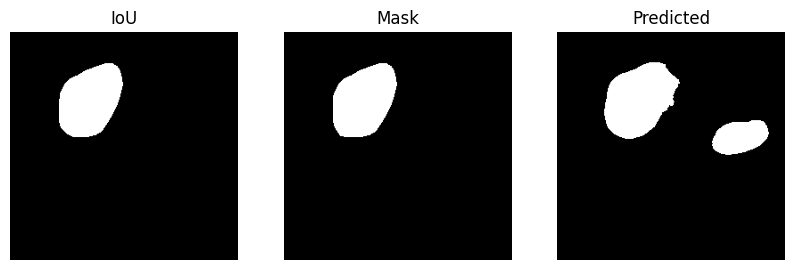

U-Net - DiceBCE
Valor IoU: 0.9587829113006592
Valor Pixel Accuracy: 0.9970855712890625


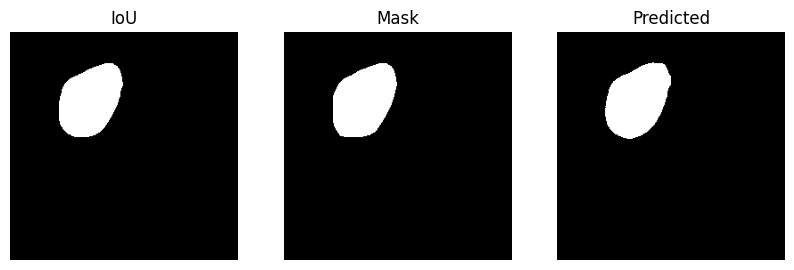

ResU-net - FocalTversky
Valor IoU: 0.6595237851142883
Valor Pixel Accuracy: 0.965087890625


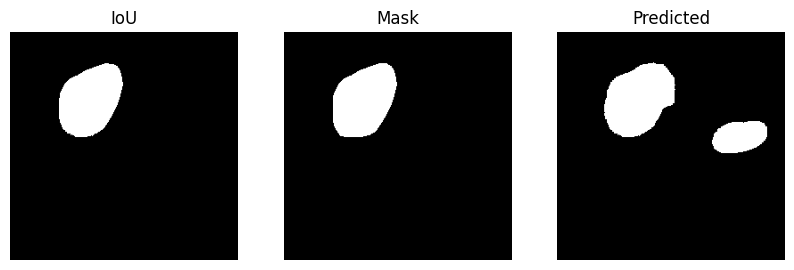

ResU-Net - DiceBCE
Valor IoU: 0.6457564830780029
Valor Pixel Accuracy: 0.96484375


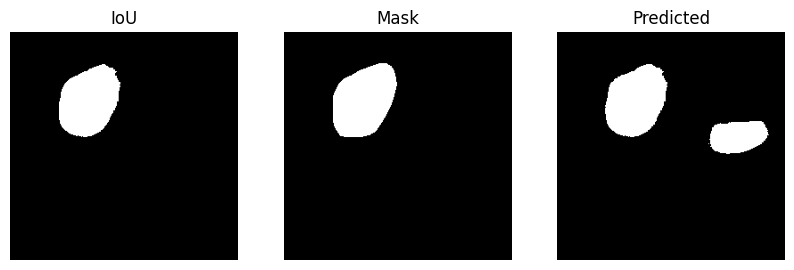

FastFCN - FocalTversky
Valor IoU: 0.9579612016677856
Valor Pixel Accuracy: 0.9970550537109375


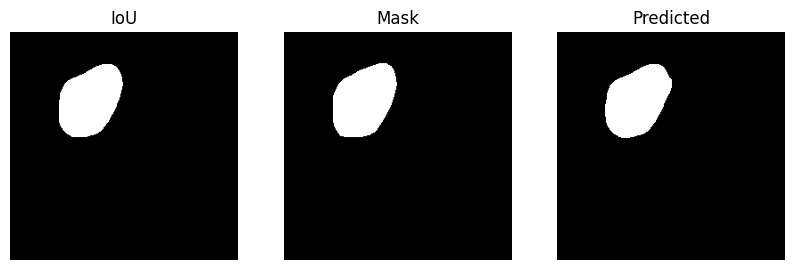

FastFCN - DiceBCE
Valor IoU: 0.9579612016677856
Valor Pixel Accuracy: 0.9970550537109375


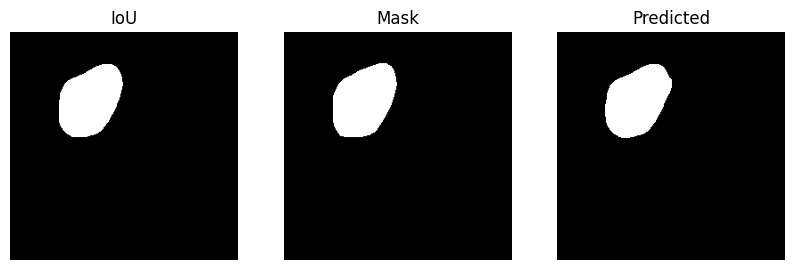

79
U-Net - FocalTversky
Valor IoU: 0.7358301877975464
Valor Pixel Accuracy: 0.951568603515625


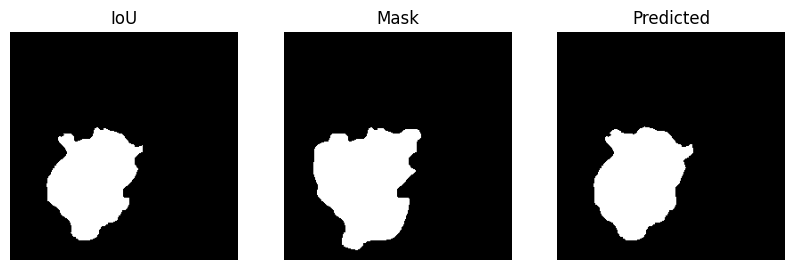

U-Net - DiceBCE
Valor IoU: 0.923149585723877
Valor Pixel Accuracy: 0.9863433837890625


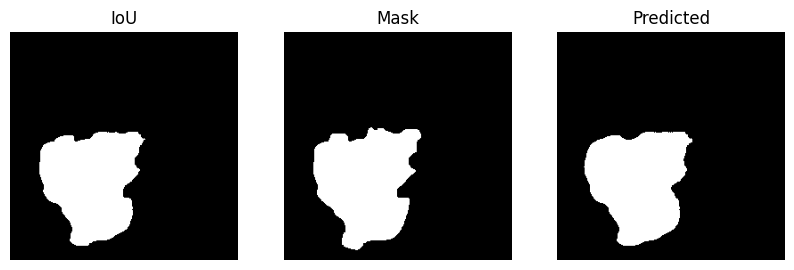

ResU-net - FocalTversky
Valor IoU: 0.15797275304794312
Valor Pixel Accuracy: 0.774627685546875


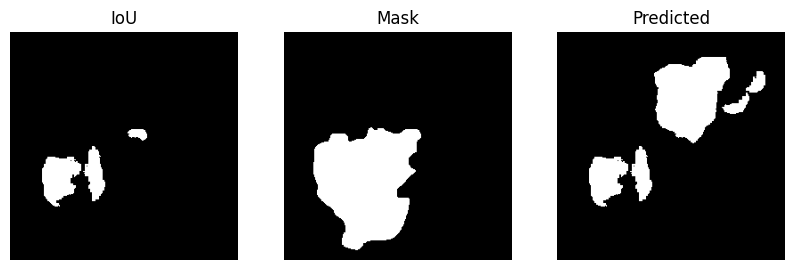

ResU-Net - DiceBCE
Valor IoU: 0.17820191383361816
Valor Pixel Accuracy: 0.80487060546875


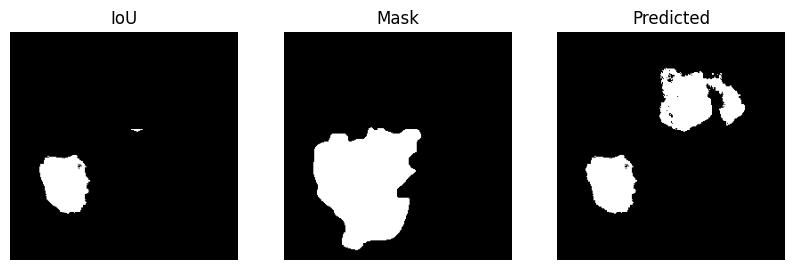

FastFCN - FocalTversky
Valor IoU: 0.919867992401123
Valor Pixel Accuracy: 0.9855499267578125


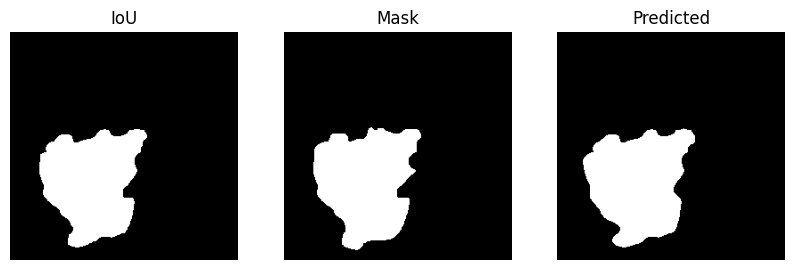

FastFCN - DiceBCE
Valor IoU: 0.919867992401123
Valor Pixel Accuracy: 0.9855499267578125


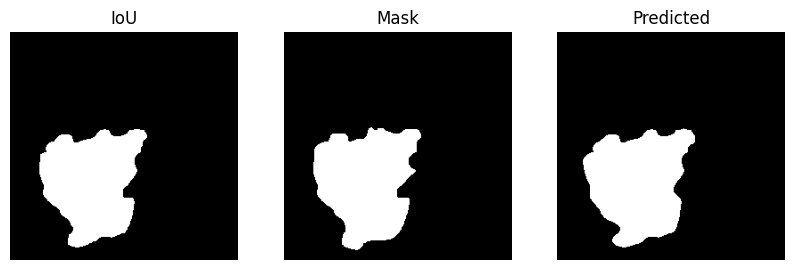

104
U-Net - FocalTversky
Valor IoU: 0.7393054962158203
Valor Pixel Accuracy: 0.992095947265625


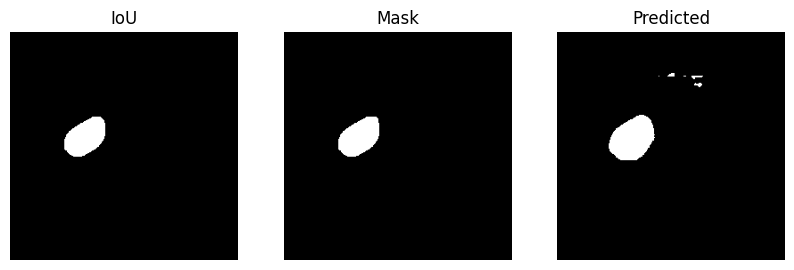

U-Net - DiceBCE
Valor IoU: 0.8322946429252625
Valor Pixel Accuracy: 0.9954833984375


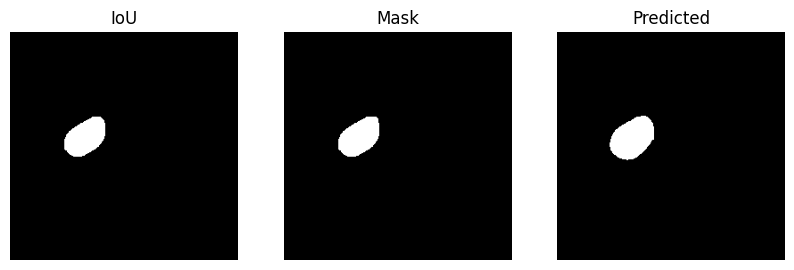

ResU-net - FocalTversky
Valor IoU: 0.6769301295280457
Valor Pixel Accuracy: 0.9892730712890625


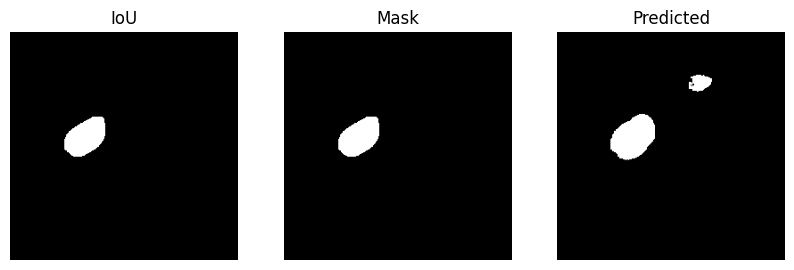

ResU-Net - DiceBCE
Valor IoU: 0.8773758411407471
Valor Pixel Accuracy: 0.9969482421875


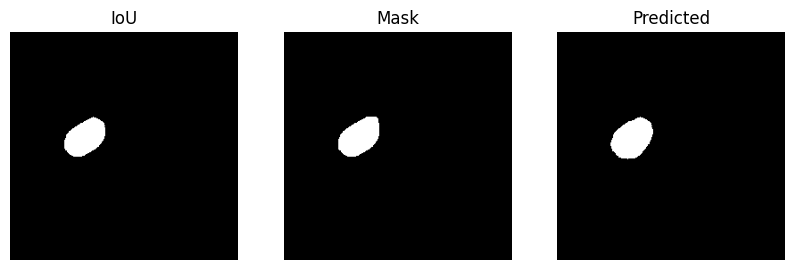

FastFCN - FocalTversky
Valor IoU: 0.8837772607803345
Valor Pixel Accuracy: 0.9970703125


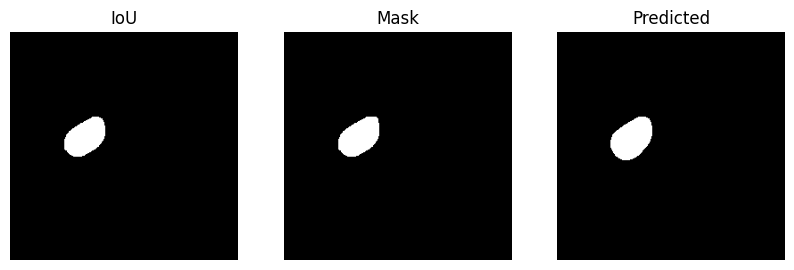

FastFCN - DiceBCE
Valor IoU: 0.8837772607803345
Valor Pixel Accuracy: 0.9970703125


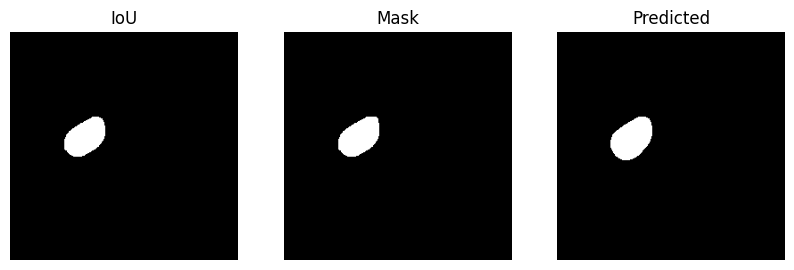

55
U-Net - FocalTversky
Valor IoU: 0.23064516484737396
Valor Pixel Accuracy: 0.9490509033203125


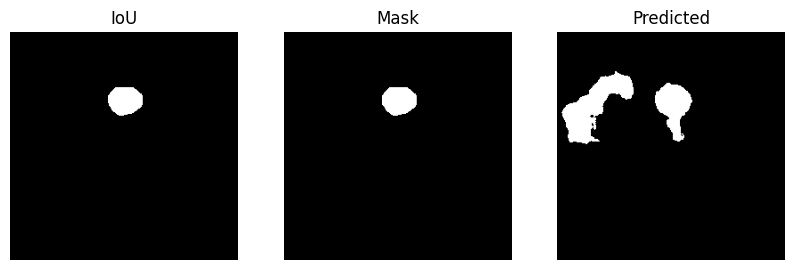

U-Net - DiceBCE
Valor IoU: 0.5320954918861389
Valor Pixel Accuracy: 0.986541748046875


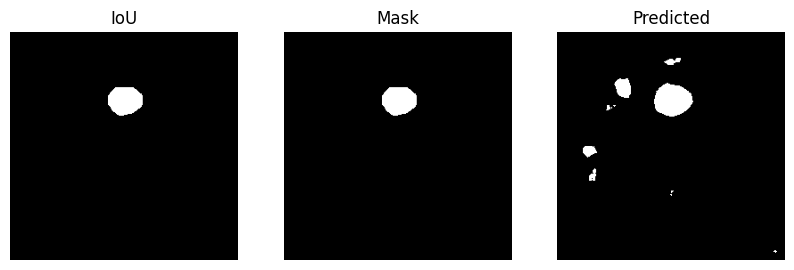

ResU-net - FocalTversky
Valor IoU: 0.37584397196769714
Valor Pixel Accuracy: 0.974609375


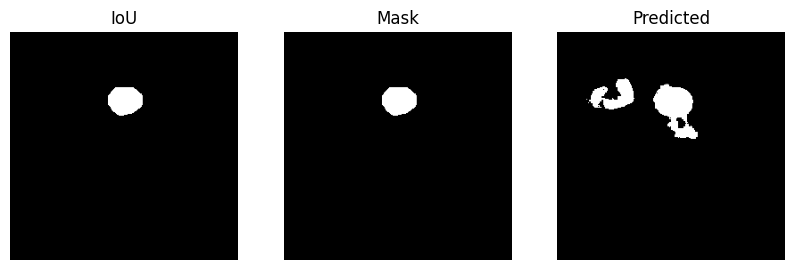

ResU-Net - DiceBCE
Valor IoU: 0.7732673287391663
Valor Pixel Accuracy: 0.9965057373046875


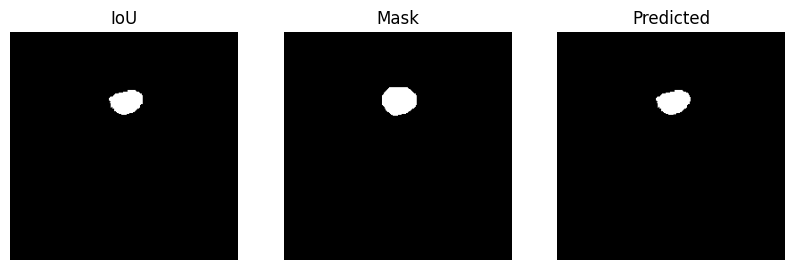

FastFCN - FocalTversky
Valor IoU: 0.6978873014450073
Valor Pixel Accuracy: 0.9934539794921875


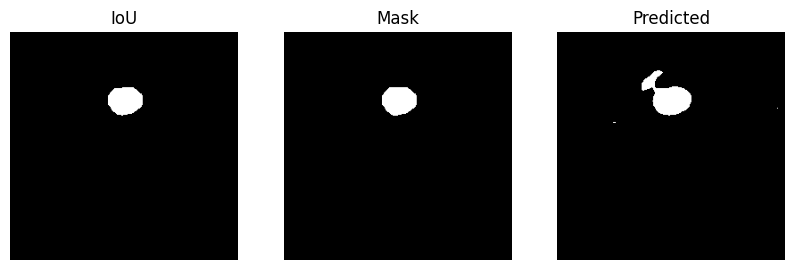

FastFCN - DiceBCE
Valor IoU: 0.6978873014450073
Valor Pixel Accuracy: 0.9934539794921875


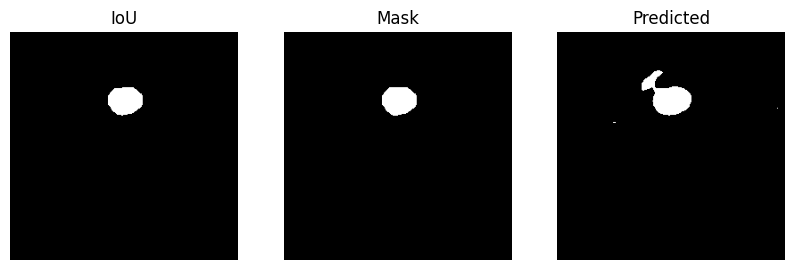

89
U-Net - FocalTversky
Valor IoU: 0.25706756114959717
Valor Pixel Accuracy: 0.9526824951171875


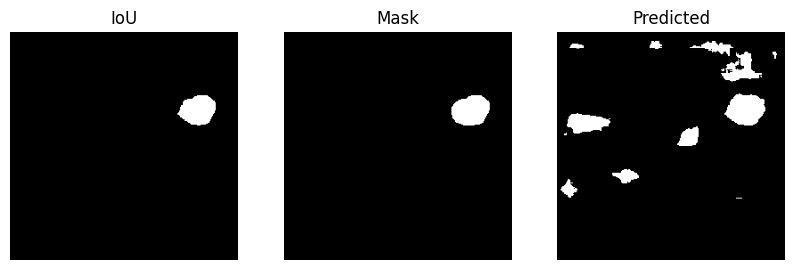

U-Net - DiceBCE
Valor IoU: 0.3232976794242859
Valor Pixel Accuracy: 0.9633026123046875


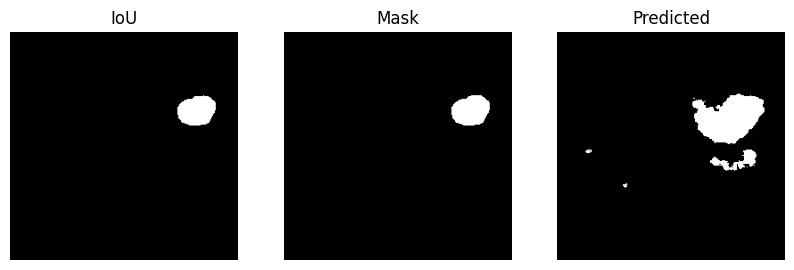

ResU-net - FocalTversky
Valor IoU: 0.1566103994846344
Valor Pixel Accuracy: 0.923004150390625


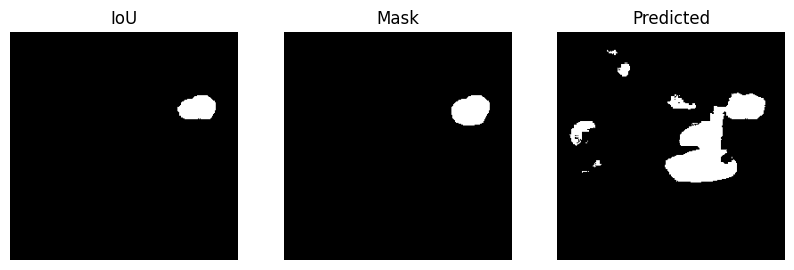

ResU-Net - DiceBCE
Valor IoU: 0.8357487916946411
Valor Pixel Accuracy: 0.99688720703125


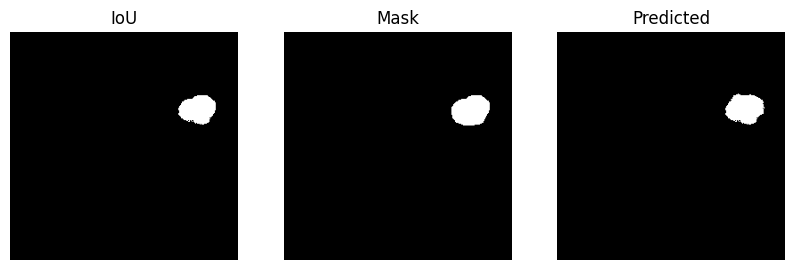

FastFCN - FocalTversky
Valor IoU: 0.9009236097335815
Valor Pixel Accuracy: 0.998199462890625


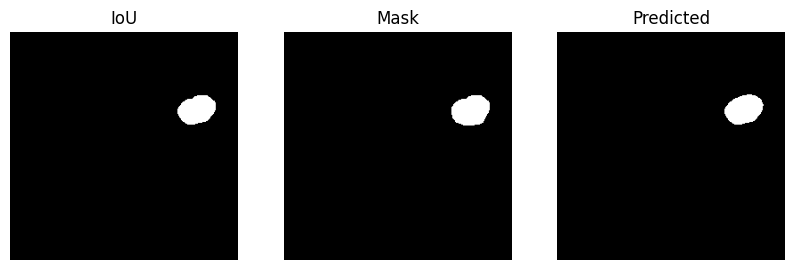

FastFCN - DiceBCE
Valor IoU: 0.9009236097335815
Valor Pixel Accuracy: 0.998199462890625


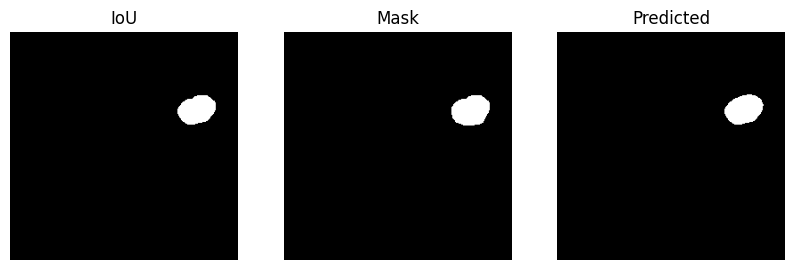

46
U-Net - FocalTversky
Valor IoU: 0.8693317174911499
Valor Pixel Accuracy: 0.98663330078125


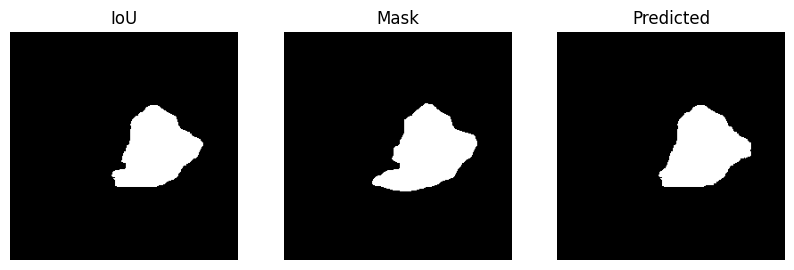

U-Net - DiceBCE
Valor IoU: 0.9142346382141113
Valor Pixel Accuracy: 0.9912109375


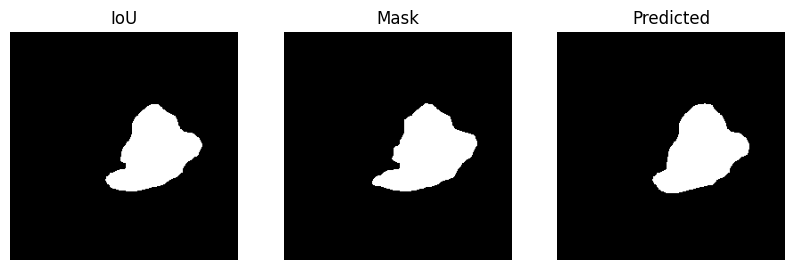

ResU-net - FocalTversky
Valor IoU: 0.5061506628990173
Valor Pixel Accuracy: 0.9454803466796875


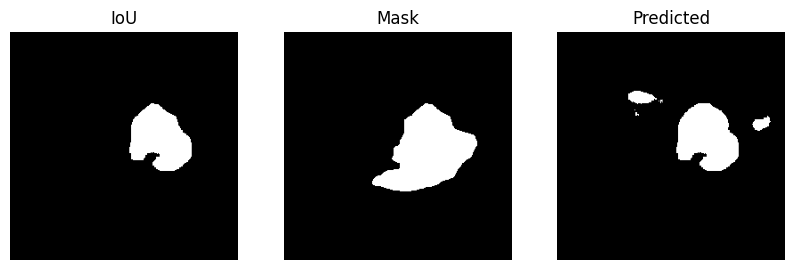

ResU-Net - DiceBCE
Valor IoU: 0.5235311985015869
Valor Pixel Accuracy: 0.952728271484375


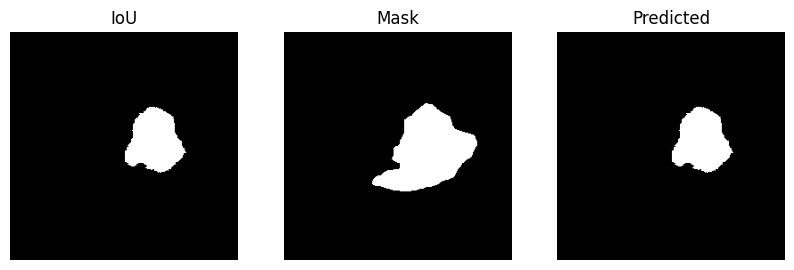

FastFCN - FocalTversky
Valor IoU: 0.8335548639297485
Valor Pixel Accuracy: 0.9828033447265625


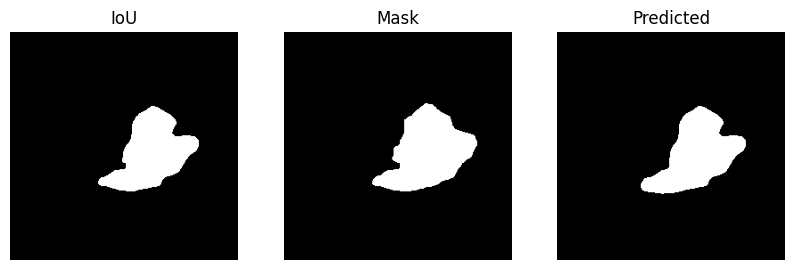

FastFCN - DiceBCE
Valor IoU: 0.8335548639297485
Valor Pixel Accuracy: 0.9828033447265625


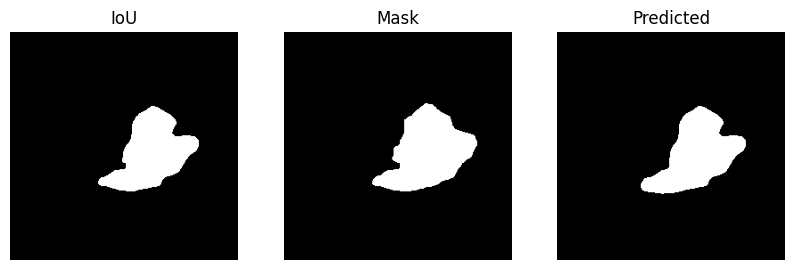

41
U-Net - FocalTversky
Valor IoU: 0.30468520522117615
Valor Pixel Accuracy: 0.9275360107421875


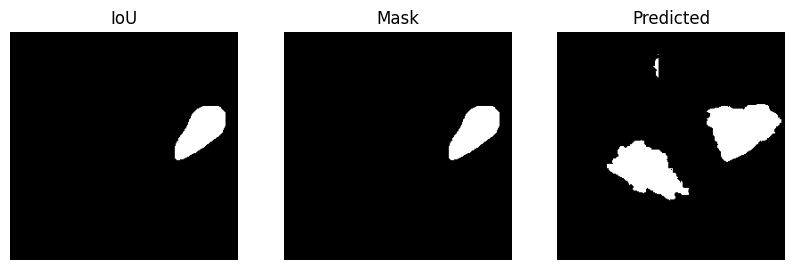

U-Net - DiceBCE
Valor IoU: 0.5469905138015747
Valor Pixel Accuracy: 0.97381591796875


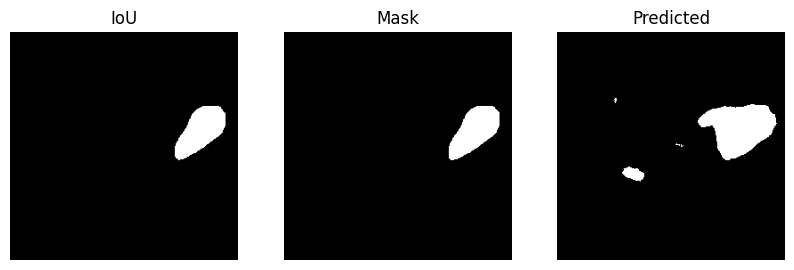

ResU-net - FocalTversky
Valor IoU: 0.35000845789909363
Valor Pixel Accuracy: 0.941314697265625


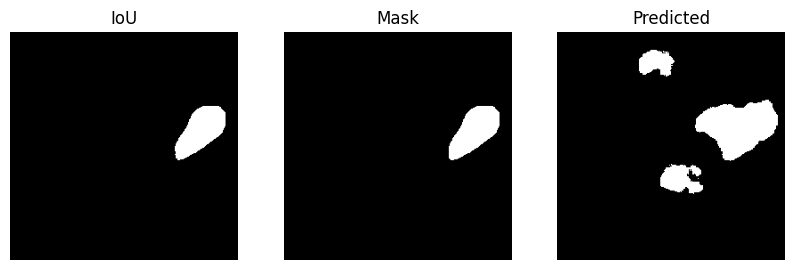

ResU-Net - DiceBCE
Valor IoU: 0.8574681282043457
Valor Pixel Accuracy: 0.9952239990234375


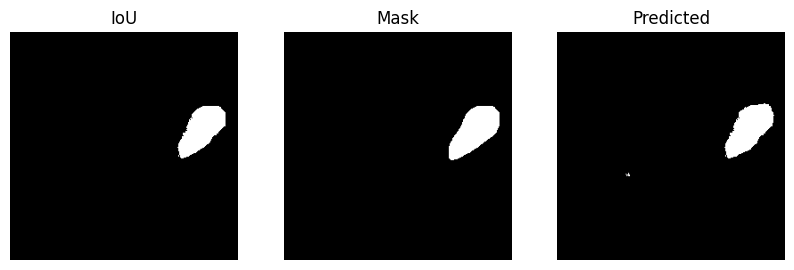

FastFCN - FocalTversky
Valor IoU: 0.8852678537368774
Valor Pixel Accuracy: 0.9960784912109375


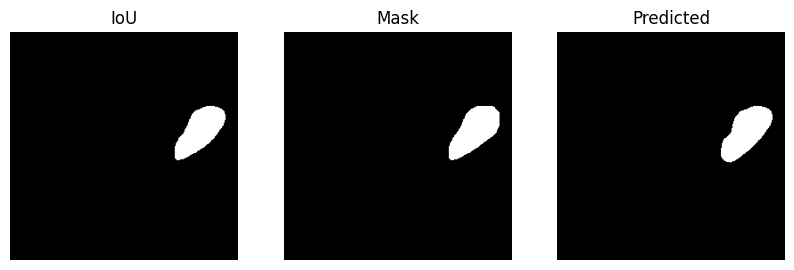

FastFCN - DiceBCE
Valor IoU: 0.8852678537368774
Valor Pixel Accuracy: 0.9960784912109375


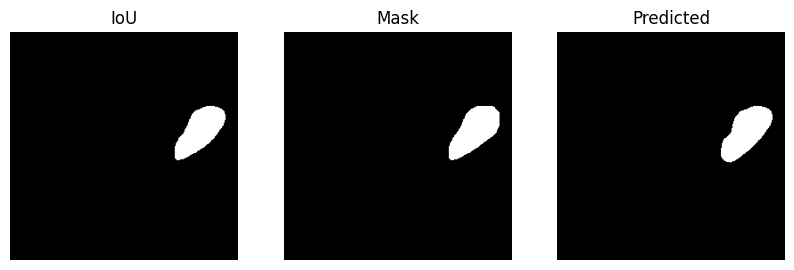

67
U-Net - FocalTversky
Valor IoU: 0.40810665488243103
Valor Pixel Accuracy: 0.7297210693359375


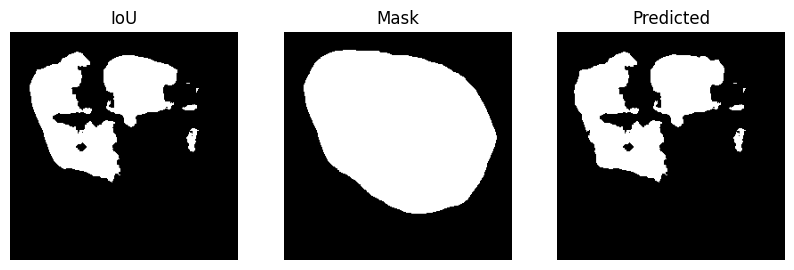

U-Net - DiceBCE
Valor IoU: 0.5408070087432861
Valor Pixel Accuracy: 0.793182373046875


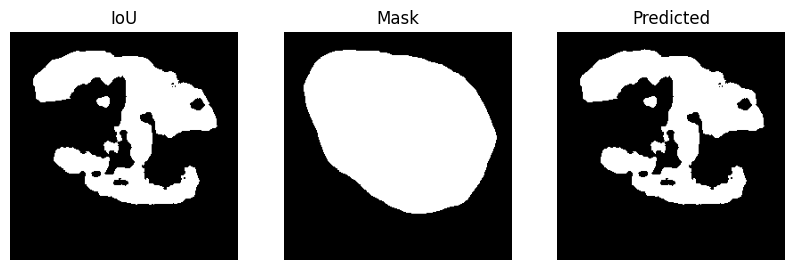

ResU-net - FocalTversky
Valor IoU: 0.2755427062511444
Valor Pixel Accuracy: 0.6669769287109375


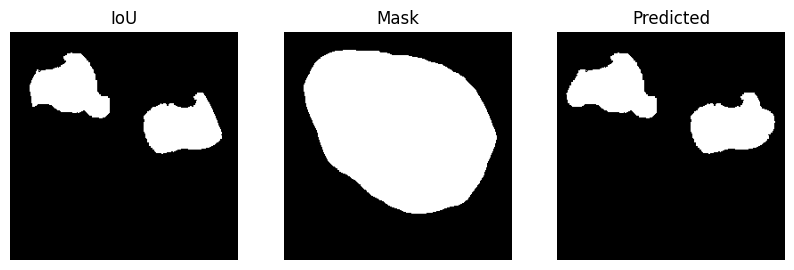

ResU-Net - DiceBCE
Valor IoU: 0.2938185930252075
Valor Pixel Accuracy: 0.6799468994140625


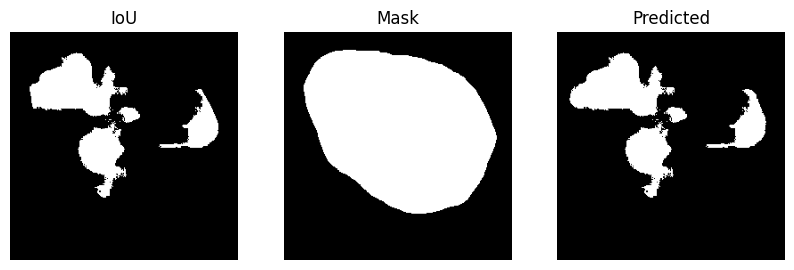

FastFCN - FocalTversky
Valor IoU: 0.6022670269012451
Valor Pixel Accuracy: 0.81903076171875


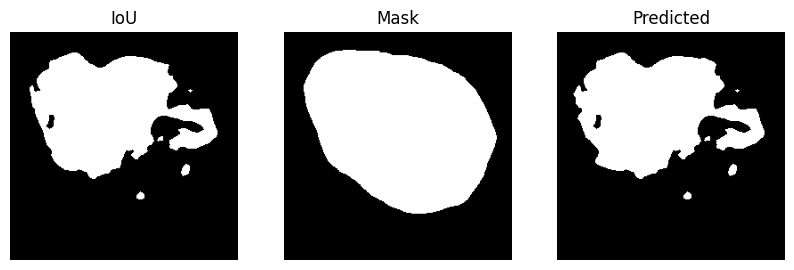

FastFCN - DiceBCE
Valor IoU: 0.6022670269012451
Valor Pixel Accuracy: 0.81903076171875


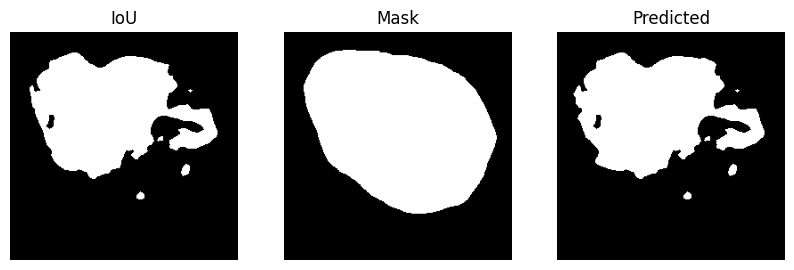

98
U-Net - FocalTversky
Valor IoU: 0.6832567453384399
Valor Pixel Accuracy: 0.890655517578125


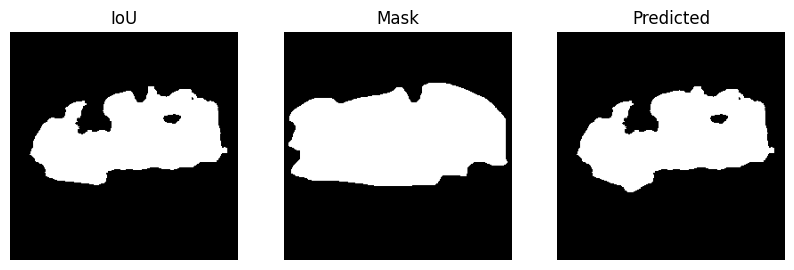

U-Net - DiceBCE
Valor IoU: 0.7633281350135803
Valor Pixel Accuracy: 0.9190521240234375


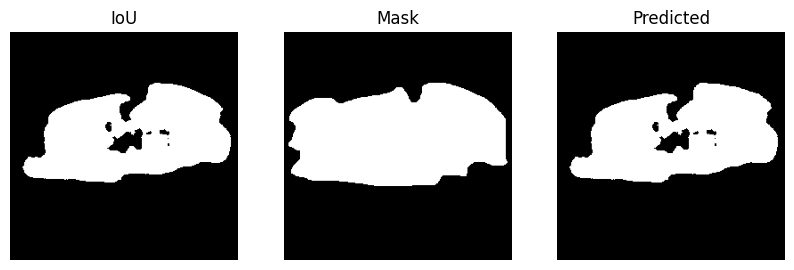

ResU-net - FocalTversky
Valor IoU: 0.5767145752906799
Valor Pixel Accuracy: 0.8558197021484375


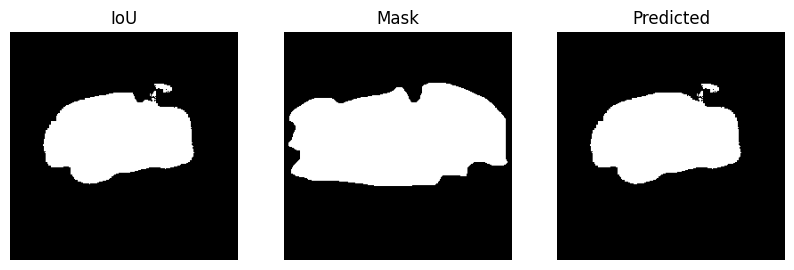

ResU-Net - DiceBCE
Valor IoU: 0.706454336643219
Valor Pixel Accuracy: 0.8995819091796875


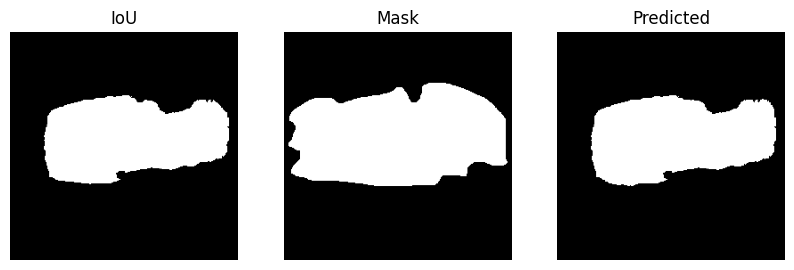

FastFCN - FocalTversky
Valor IoU: 0.8912350535392761
Valor Pixel Accuracy: 0.9625091552734375


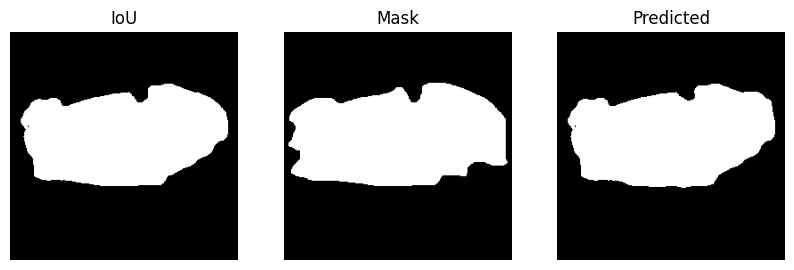

FastFCN - DiceBCE
Valor IoU: 0.8912350535392761
Valor Pixel Accuracy: 0.9625091552734375


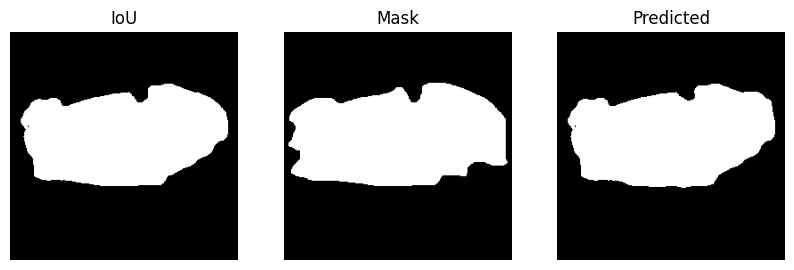

6
U-Net - FocalTversky
Valor IoU: 0.8637510538101196
Valor Pixel Accuracy: 0.992584228515625


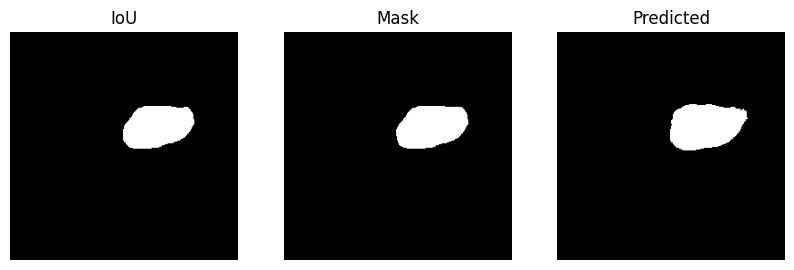

U-Net - DiceBCE
Valor IoU: 0.8143616914749146
Valor Pixel Accuracy: 0.989349365234375


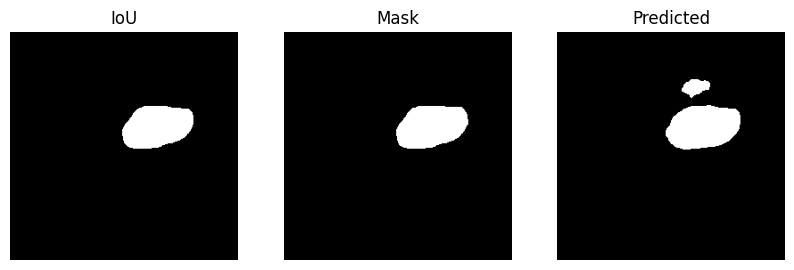

ResU-net - FocalTversky
Valor IoU: 0.6778215169906616
Valor Pixel Accuracy: 0.9775238037109375


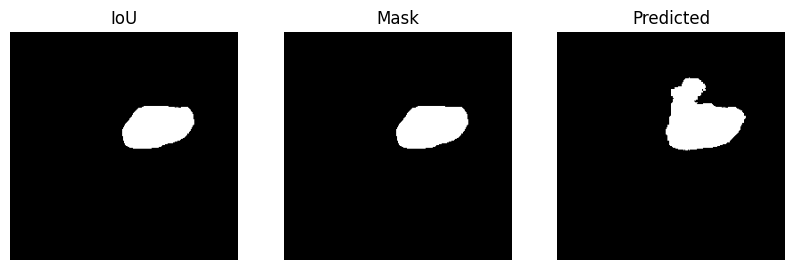

ResU-Net - DiceBCE
Valor IoU: 0.8114797472953796
Valor Pixel Accuracy: 0.98907470703125


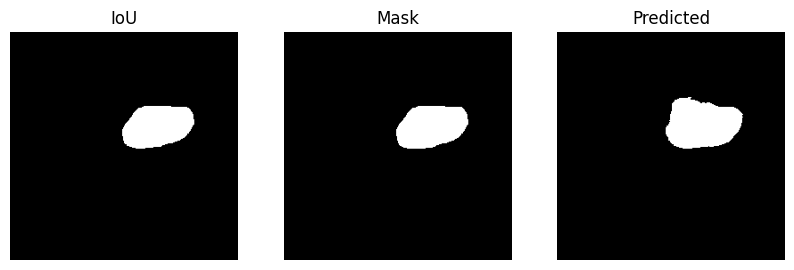

FastFCN - FocalTversky
Valor IoU: 0.9264437556266785
Valor Pixel Accuracy: 0.996307373046875


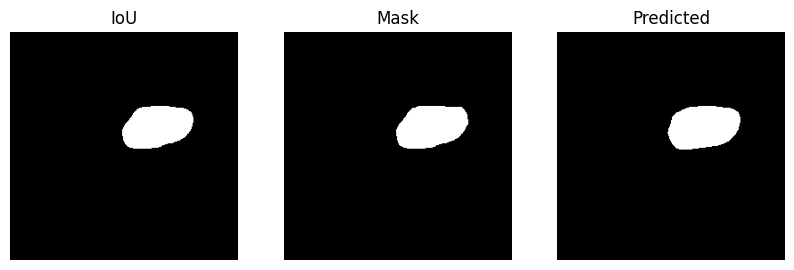

FastFCN - DiceBCE
Valor IoU: 0.9264437556266785
Valor Pixel Accuracy: 0.996307373046875


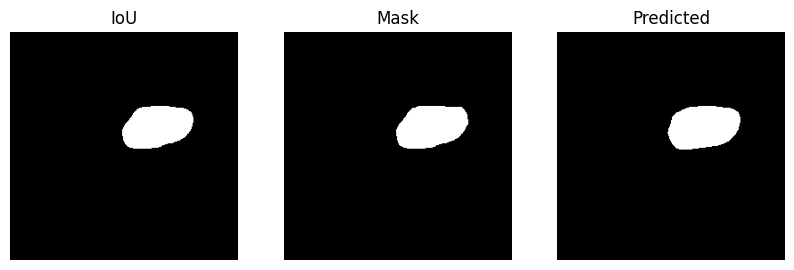

In [ ]:
plot_IoU(netlist)

63
Unet FT
Valor IoU: 0.6497449278831482
Valor Pixel Accuracy: 0.9570465087890625


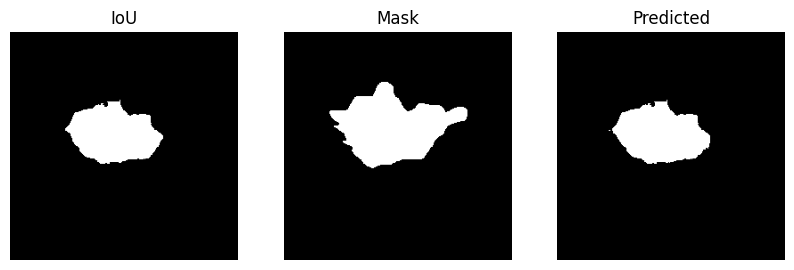

Unet DBCE
Valor IoU: 0.873636782169342
Valor Pixel Accuracy: 0.983734130859375


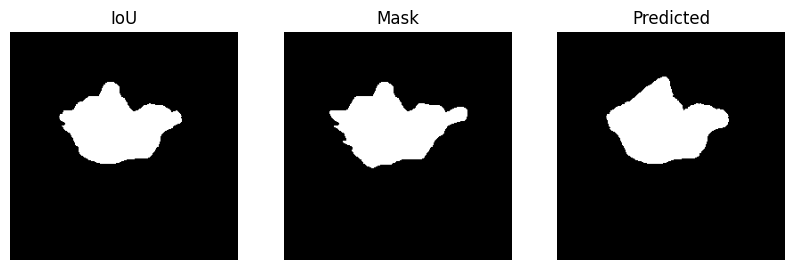

ResUnet FT
Valor IoU: 0.27843016386032104
Valor Pixel Accuracy: 0.8931121826171875


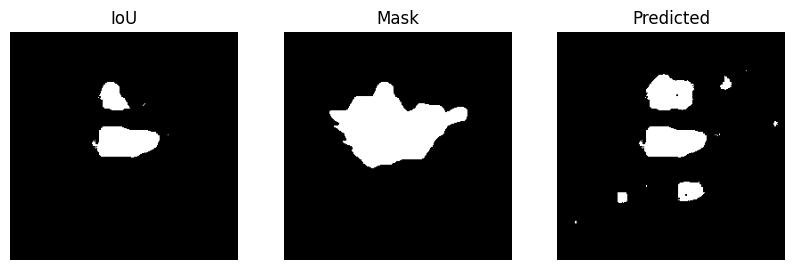

ResUnet DBCE
Valor IoU: 0.07864894717931747
Valor Pixel Accuracy: 0.88470458984375


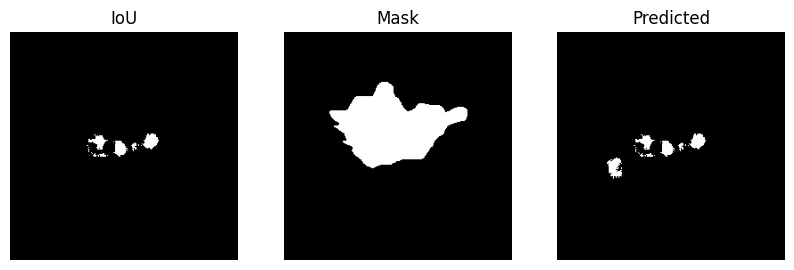

FastFCN FT
Valor IoU: 0.8166102766990662
Valor Pixel Accuracy: 0.9768524169921875


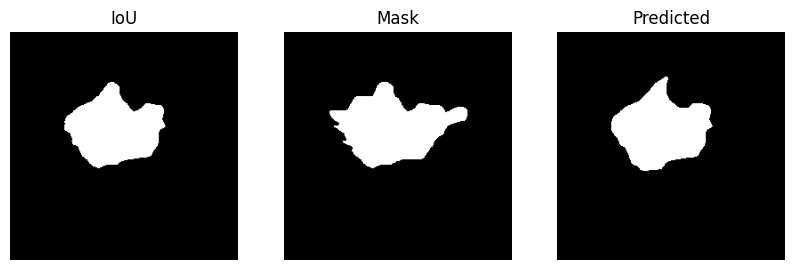

FastFCN DBCE
Valor IoU: 0.8166102766990662
Valor Pixel Accuracy: 0.9768524169921875


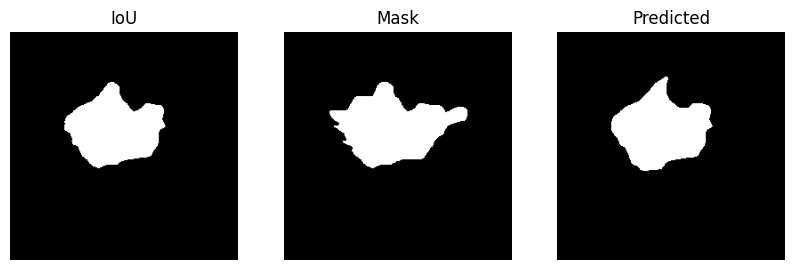

27
Unet FT
Valor IoU: 0.8836227059364319
Valor Pixel Accuracy: 0.9886474609375


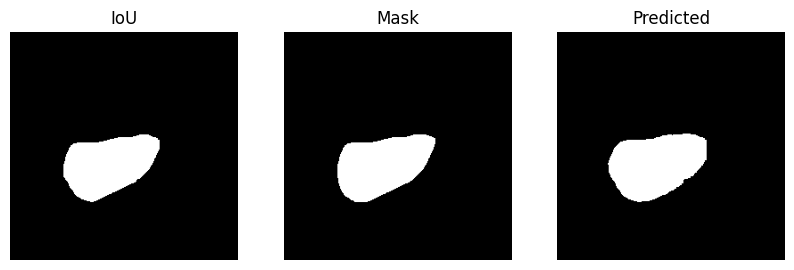

Unet DBCE
Valor IoU: 0.9252244830131531
Valor Pixel Accuracy: 0.993011474609375


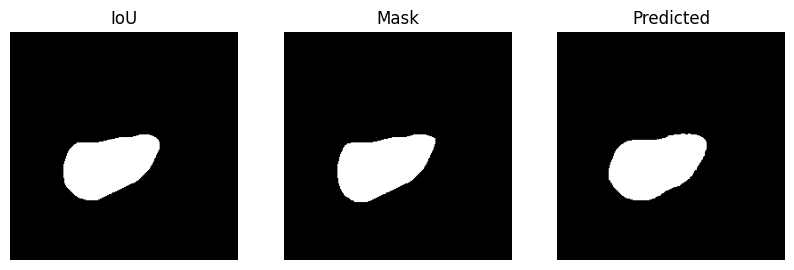

ResUnet FT
Valor IoU: 0.6429442763328552
Valor Pixel Accuracy: 0.959808349609375


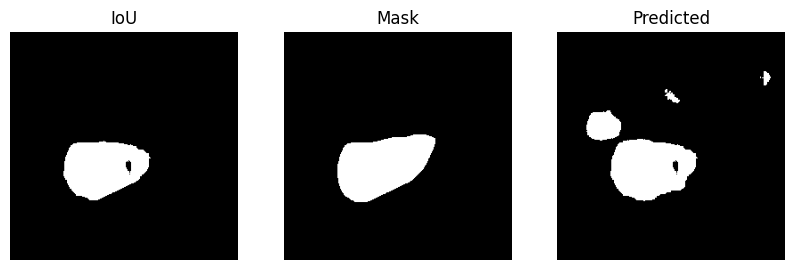

ResUnet DBCE
Valor IoU: 0.5706075429916382
Valor Pixel Accuracy: 0.9600982666015625


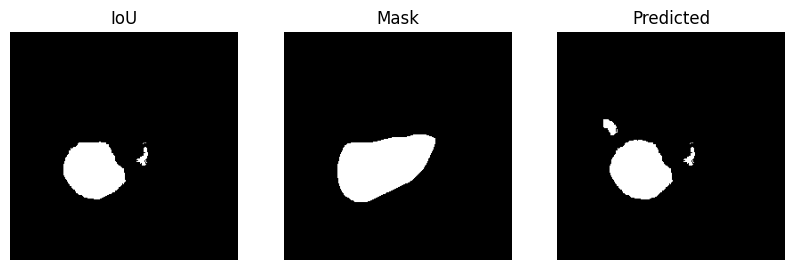

FastFCN FT
Valor IoU: 0.9203395247459412
Valor Pixel Accuracy: 0.9925537109375


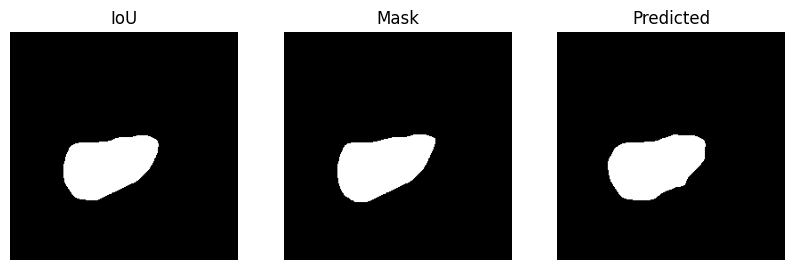

FastFCN DBCE
Valor IoU: 0.9203395247459412
Valor Pixel Accuracy: 0.9925537109375


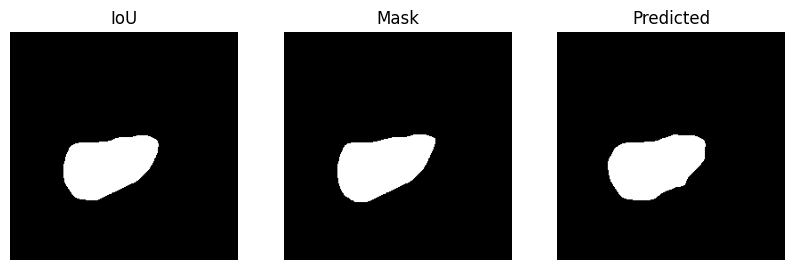

73
Unet FT
Valor IoU: 0.7354961633682251
Valor Pixel Accuracy: 0.894256591796875


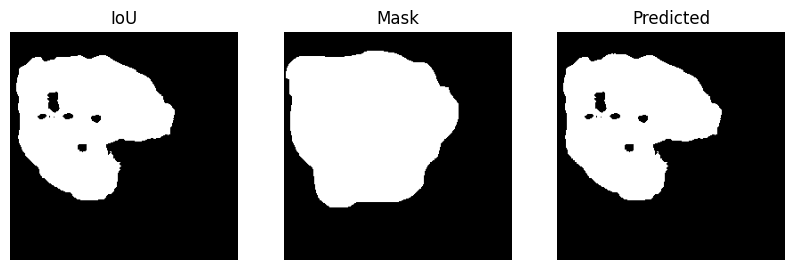

Unet DBCE
Valor IoU: 0.6816705465316772
Valor Pixel Accuracy: 0.8728790283203125


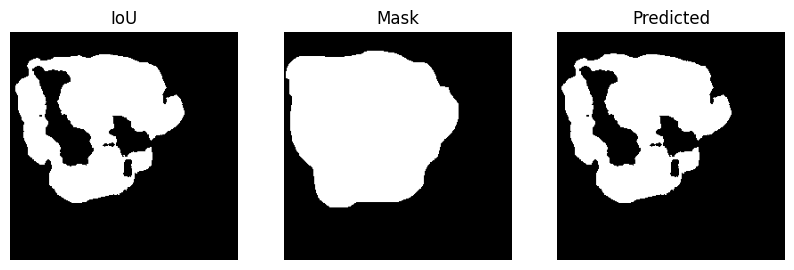

ResUnet FT
Valor IoU: 0.4019118547439575
Valor Pixel Accuracy: 0.7622833251953125


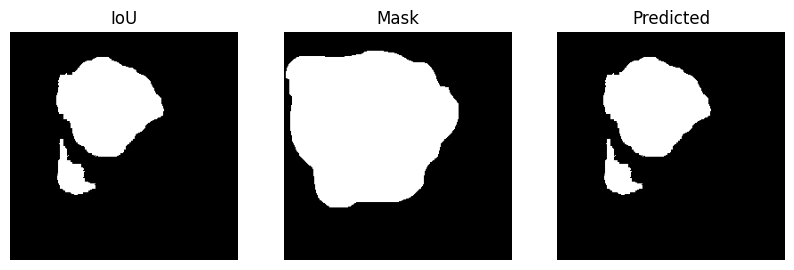

ResUnet DBCE
Valor IoU: 0.31541767716407776
Valor Pixel Accuracy: 0.7279052734375


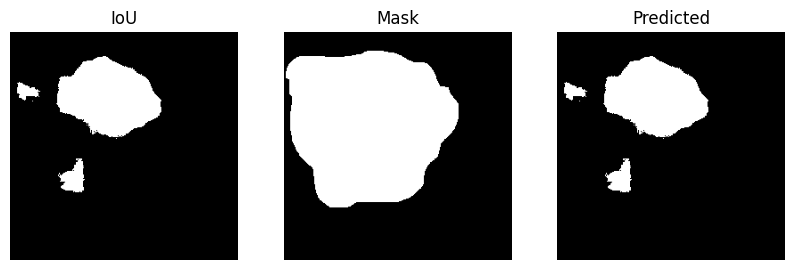

FastFCN FT
Valor IoU: 0.729640543460846
Valor Pixel Accuracy: 0.8924560546875


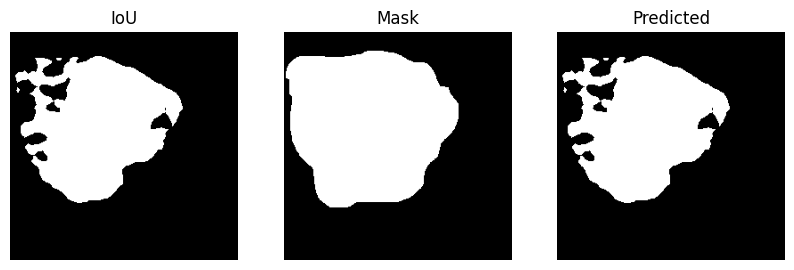

FastFCN DBCE
Valor IoU: 0.729640543460846
Valor Pixel Accuracy: 0.8924560546875


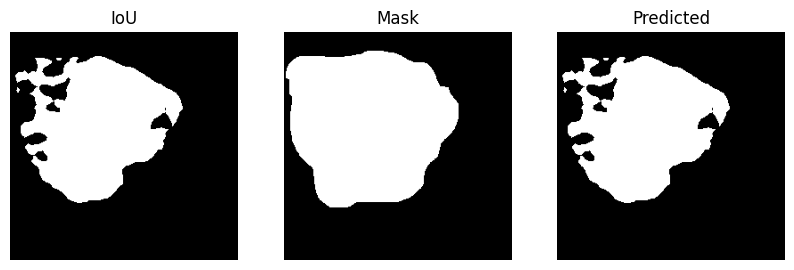

113
Unet FT
Valor IoU: 0.7434688210487366
Valor Pixel Accuracy: 0.9892120361328125


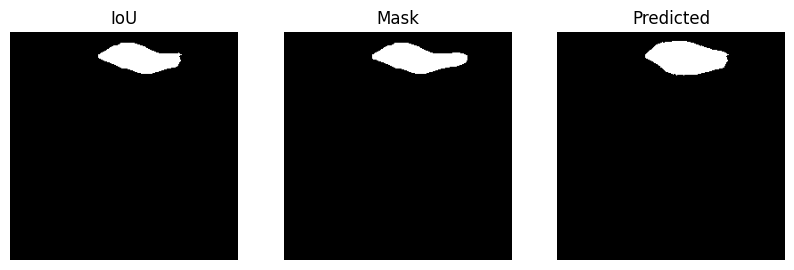

Unet DBCE
Valor IoU: 0.8322749137878418
Valor Pixel Accuracy: 0.9931488037109375


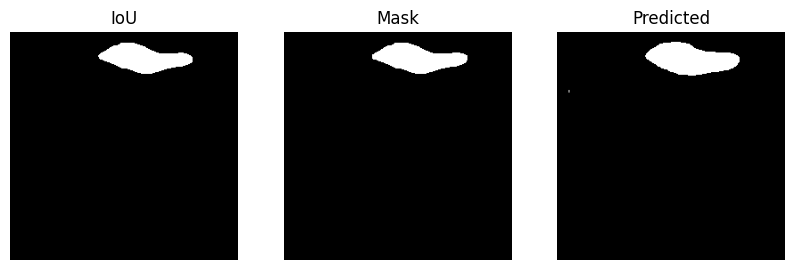

ResUnet FT
Valor IoU: 0.474392831325531
Valor Pixel Accuracy: 0.9696197509765625


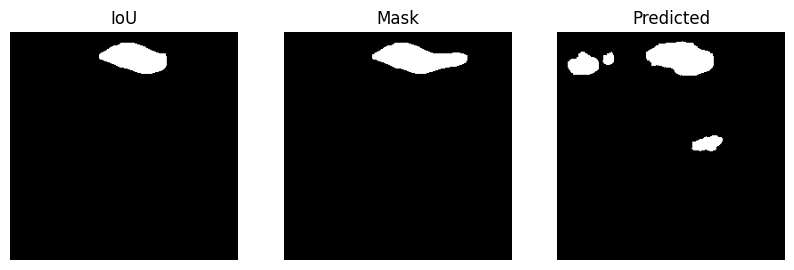

ResUnet DBCE
Valor IoU: 0.009079118259251118
Valor Pixel Accuracy: 0.96502685546875


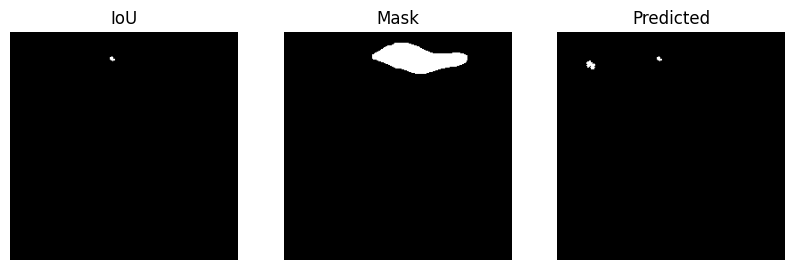

FastFCN FT
Valor IoU: 0.9020184874534607
Valor Pixel Accuracy: 0.9964447021484375


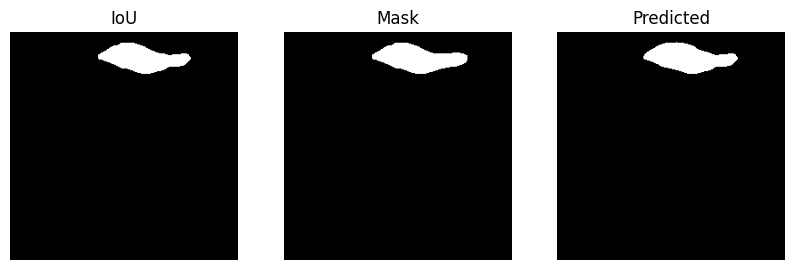

FastFCN DBCE
Valor IoU: 0.9020184874534607
Valor Pixel Accuracy: 0.9964447021484375


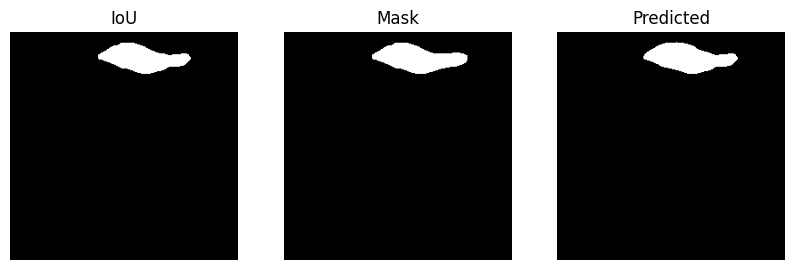

76
Unet FT
Valor IoU: 0.8452620506286621
Valor Pixel Accuracy: 0.970672607421875


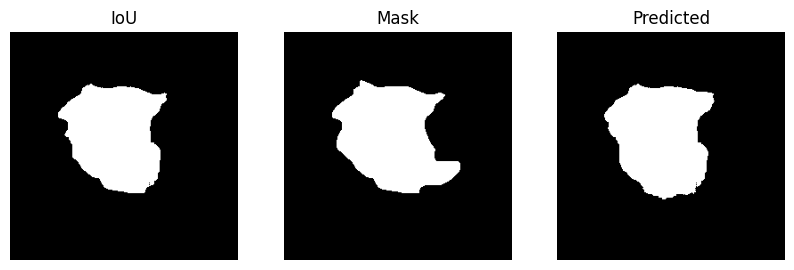

Unet DBCE
Valor IoU: 0.9055299758911133
Valor Pixel Accuracy: 0.9818572998046875


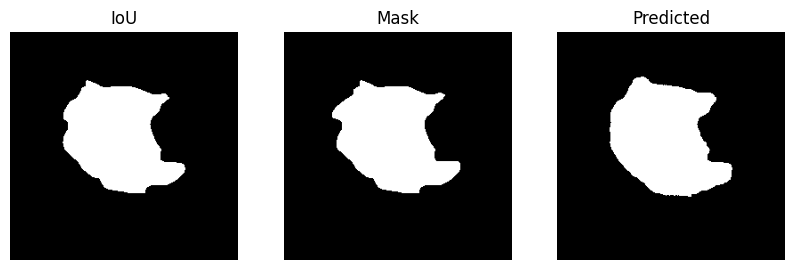

ResUnet FT
Valor IoU: 0.6711779236793518
Valor Pixel Accuracy: 0.93994140625


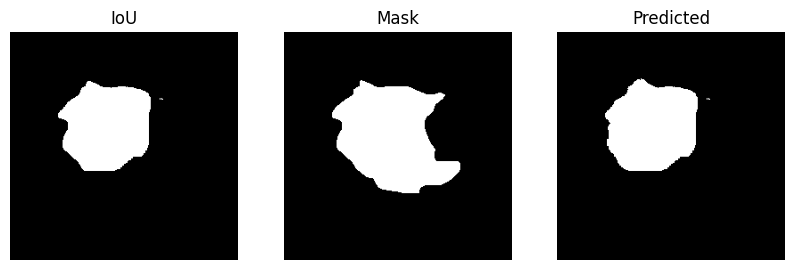

ResUnet DBCE
Valor IoU: 0.666448175907135
Valor Pixel Accuracy: 0.9378814697265625


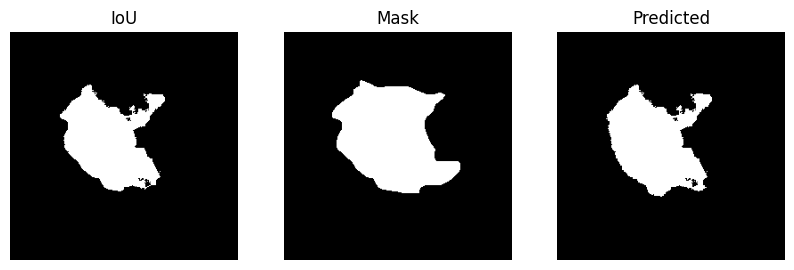

FastFCN FT
Valor IoU: 0.9176120162010193
Valor Pixel Accuracy: 0.9848175048828125


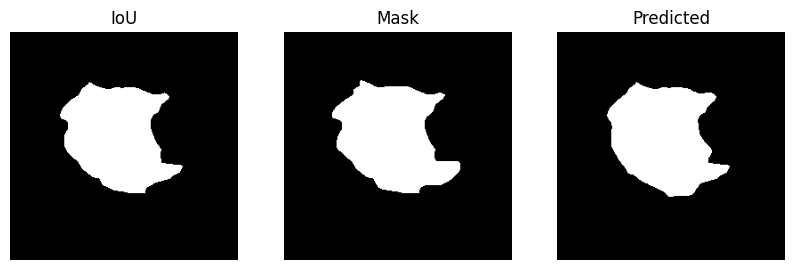

FastFCN DBCE
Valor IoU: 0.9176120162010193
Valor Pixel Accuracy: 0.9848175048828125


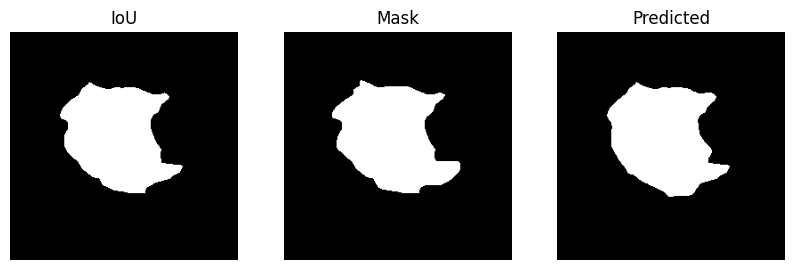

95
Unet FT
Valor IoU: 0.8269856572151184
Valor Pixel Accuracy: 0.9862060546875


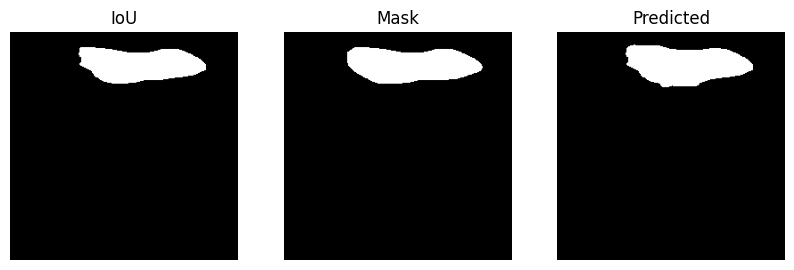

Unet DBCE
Valor IoU: 0.8645636439323425
Valor Pixel Accuracy: 0.99017333984375


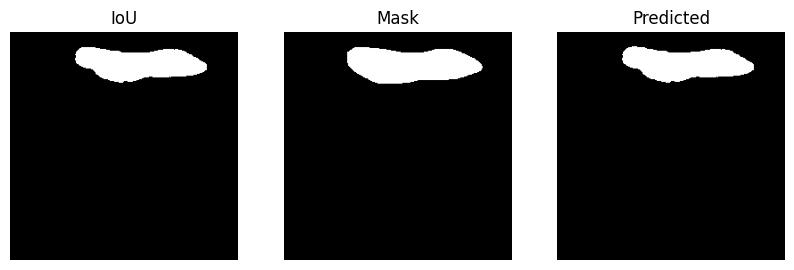

ResUnet FT
Valor IoU: 0.5722566246986389
Valor Pixel Accuracy: 0.96734619140625


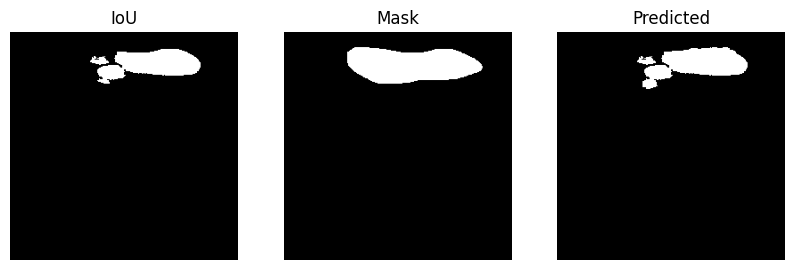

ResUnet DBCE
Valor IoU: 0.7662795782089233
Valor Pixel Accuracy: 0.9828033447265625


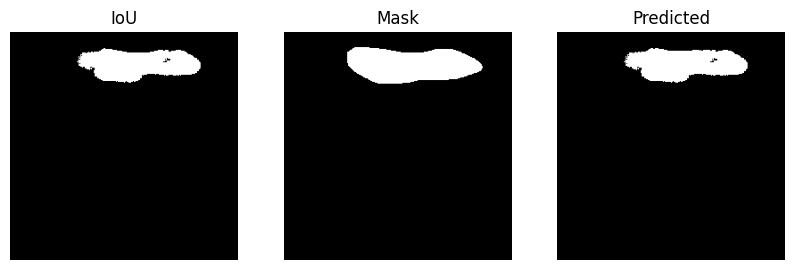

FastFCN FT
Valor IoU: 0.9010022282600403
Valor Pixel Accuracy: 0.99261474609375


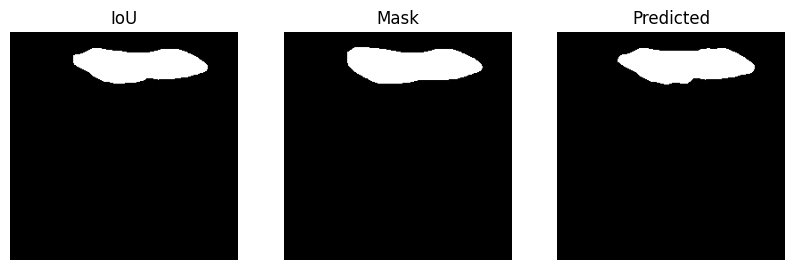

FastFCN DBCE
Valor IoU: 0.9010022282600403
Valor Pixel Accuracy: 0.99261474609375


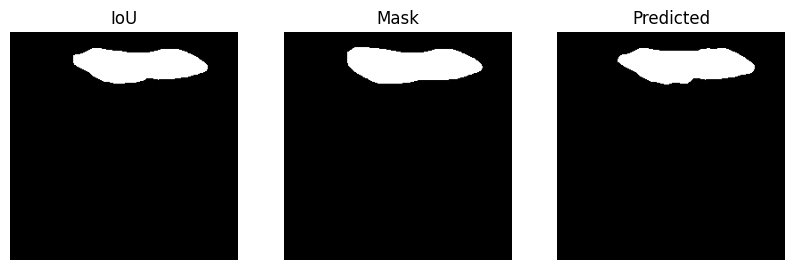

90
Unet FT
Valor IoU: 0.8419947624206543
Valor Pixel Accuracy: 0.990814208984375


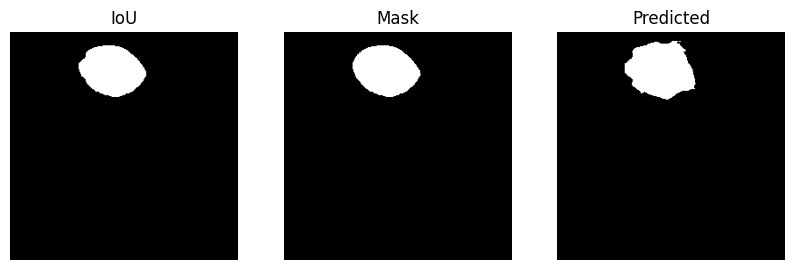

Unet DBCE
Valor IoU: 0.8944864273071289
Valor Pixel Accuracy: 0.9942474365234375


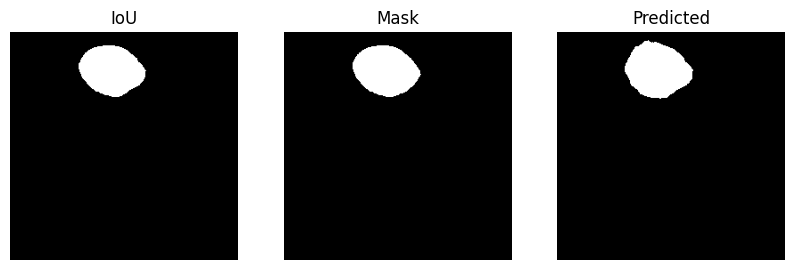

ResUnet FT
Valor IoU: 0.8691256642341614
Valor Pixel Accuracy: 0.9926910400390625


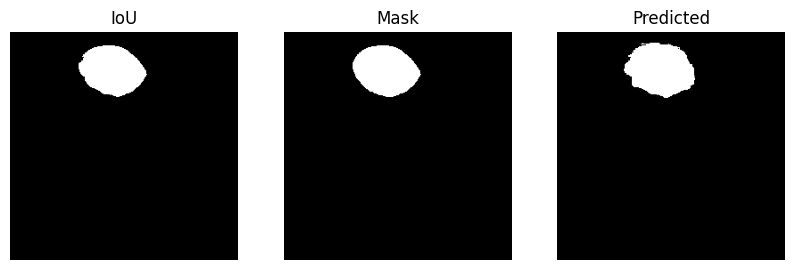

ResUnet DBCE
Valor IoU: 0.8037839531898499
Valor Pixel Accuracy: 0.9901885986328125


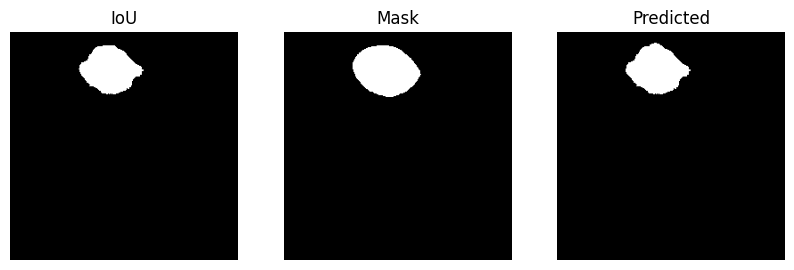

FastFCN FT
Valor IoU: 0.9024106860160828
Valor Pixel Accuracy: 0.994873046875


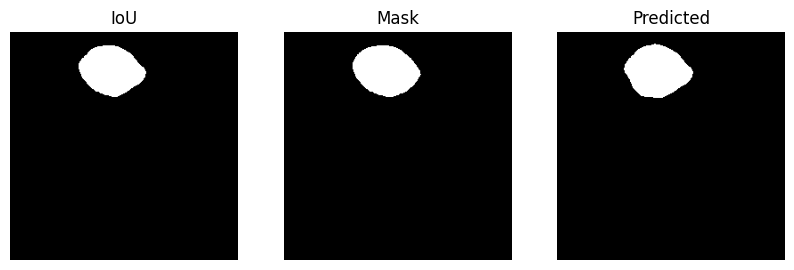

FastFCN DBCE
Valor IoU: 0.9024106860160828
Valor Pixel Accuracy: 0.994873046875


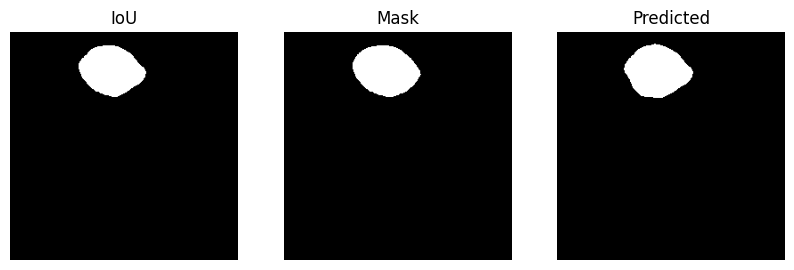

63
Unet FT
Valor IoU: 0.6598345637321472
Valor Pixel Accuracy: 0.9579620361328125


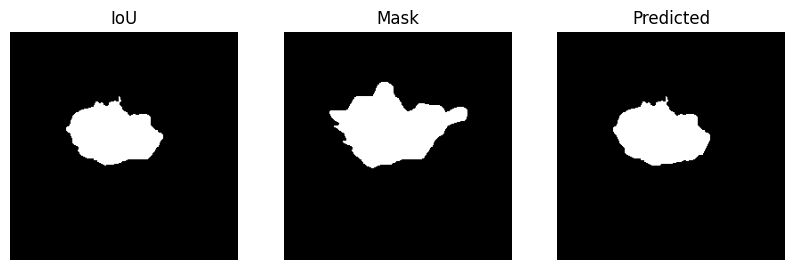

Unet DBCE
Valor IoU: 0.8901203870773315
Valor Pixel Accuracy: 0.985931396484375


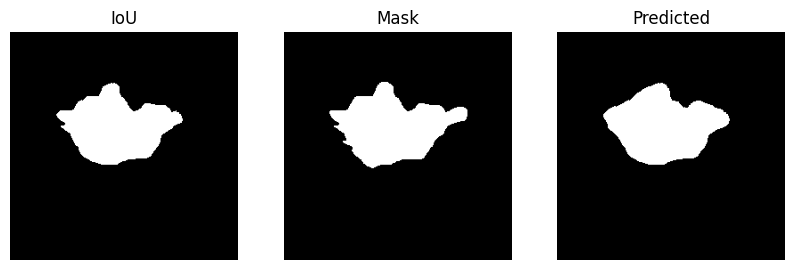

ResUnet FT
Valor IoU: 0.3273352384567261
Valor Pixel Accuracy: 0.9104461669921875


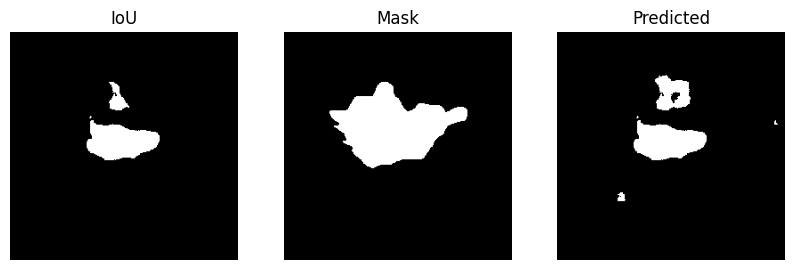

ResUnet DBCE
Valor IoU: 0.06048198416829109
Valor Pixel Accuracy: 0.8774566650390625


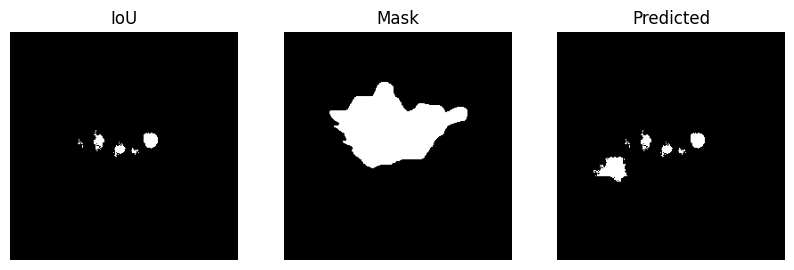

FastFCN FT
Valor IoU: 0.8166102766990662
Valor Pixel Accuracy: 0.9768524169921875


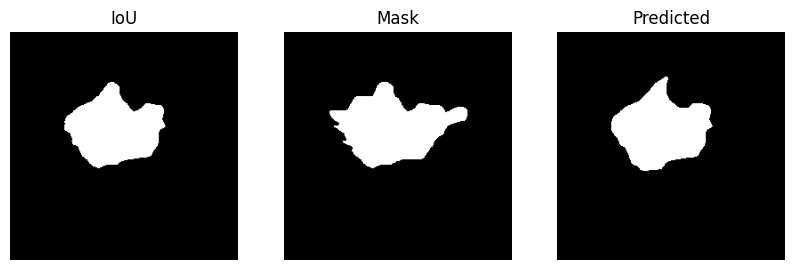

FastFCN DBCE
Valor IoU: 0.8166102766990662
Valor Pixel Accuracy: 0.9768524169921875


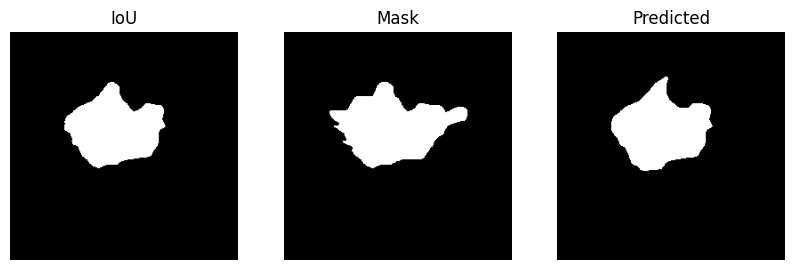

11
Unet FT
Valor IoU: 0.7865281701087952
Valor Pixel Accuracy: 0.9902801513671875


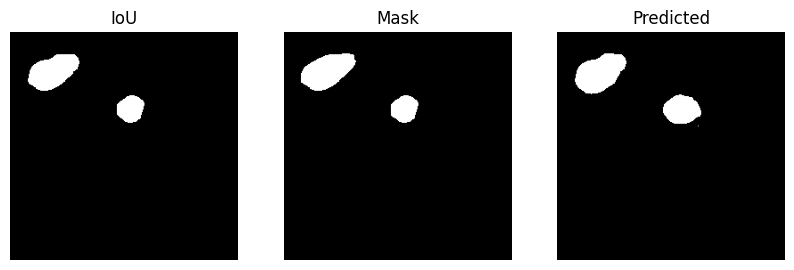

Unet DBCE
Valor IoU: 0.8788876533508301
Valor Pixel Accuracy: 0.9949493408203125


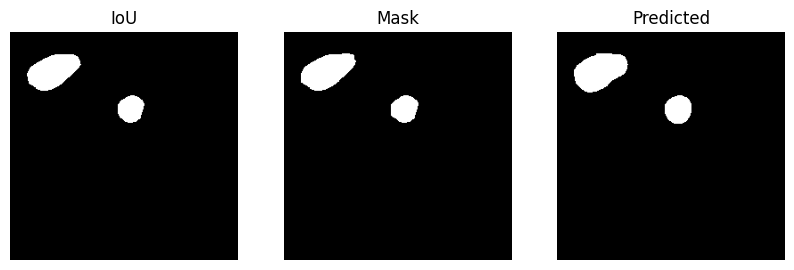

ResUnet FT
Valor IoU: 0.808095395565033
Valor Pixel Accuracy: 0.9918975830078125


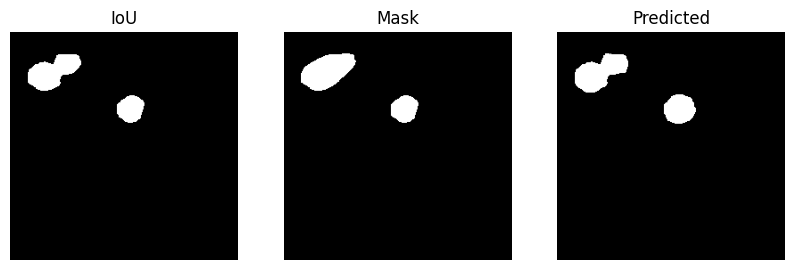

ResUnet DBCE
Valor IoU: 0.8328161239624023
Valor Pixel Accuracy: 0.9934234619140625


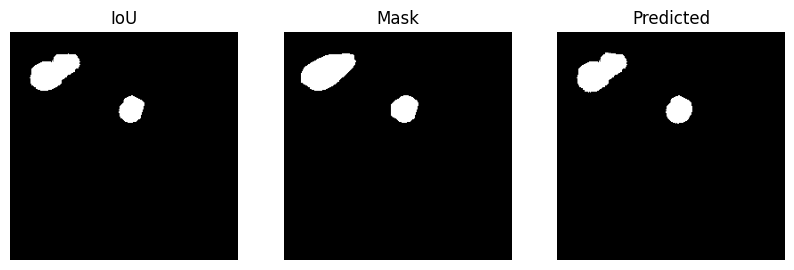

FastFCN FT
Valor IoU: 0.8747268915176392
Valor Pixel Accuracy: 0.9947509765625


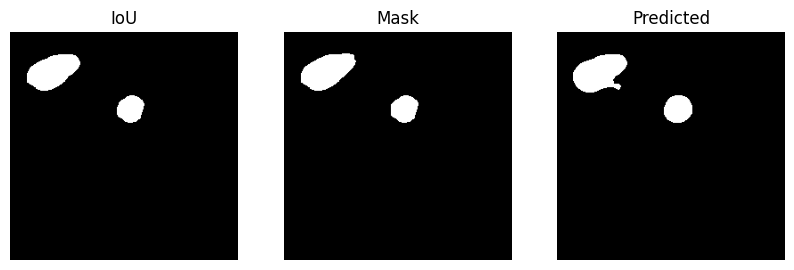

FastFCN DBCE
Valor IoU: 0.8747268915176392
Valor Pixel Accuracy: 0.9947509765625


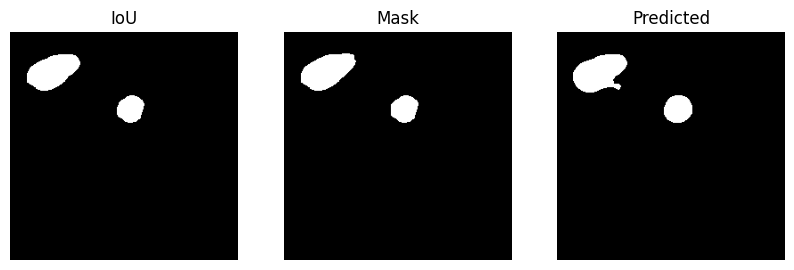

95
Unet FT
Valor IoU: 0.8338130712509155
Valor Pixel Accuracy: 0.986785888671875


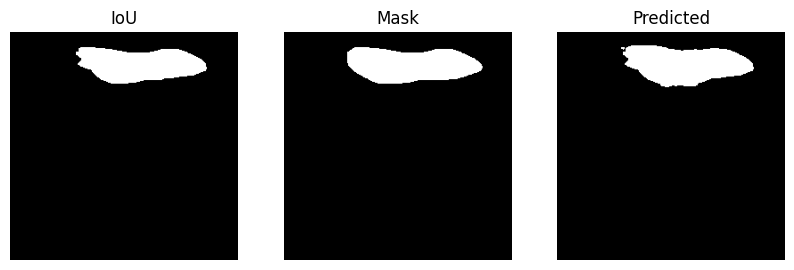

Unet DBCE
Valor IoU: 0.8763406872749329
Valor Pixel Accuracy: 0.99102783203125


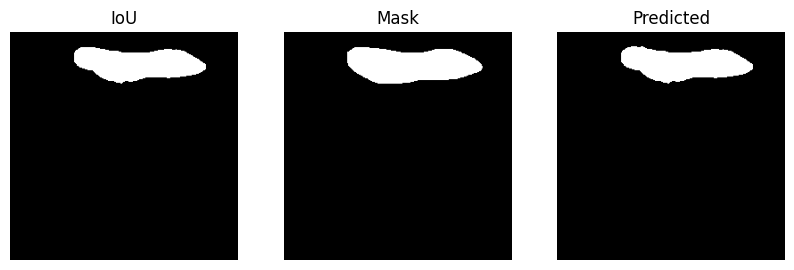

ResUnet FT
Valor IoU: 0.5988130569458008
Valor Pixel Accuracy: 0.96905517578125


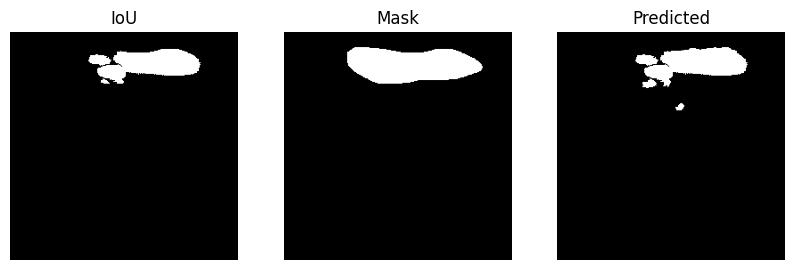

ResUnet DBCE
Valor IoU: 0.7356297969818115
Valor Pixel Accuracy: 0.980560302734375


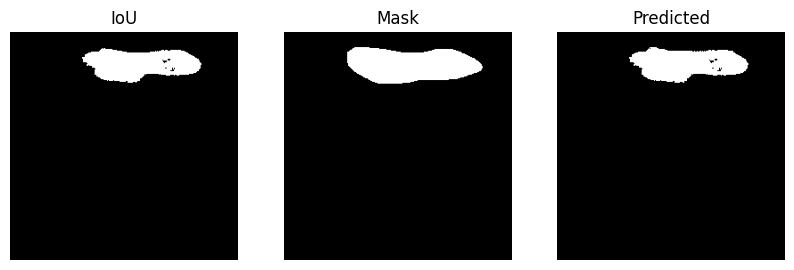

FastFCN FT
Valor IoU: 0.9010022282600403
Valor Pixel Accuracy: 0.99261474609375


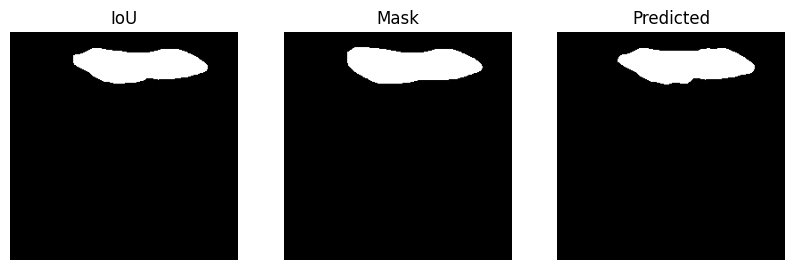

FastFCN DBCE
Valor IoU: 0.9010022282600403
Valor Pixel Accuracy: 0.99261474609375


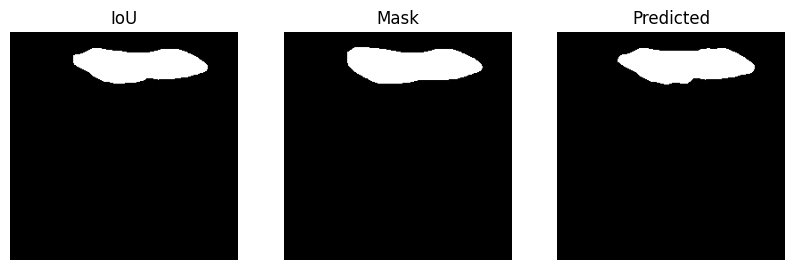

In [ ]:
plot_IoU(netlist)

In [ ]:
mean_IoU_pixel(netlist)

Unet FT:
	 Média IoU: 0.6242905473766419 
	 Média pixel accuracy: 0.9513518113356371
Unet DBCE:
	 Média IoU: 0.7231227870744008 
	 Média pixel accuracy: 0.9679585383488581
ResUnet FT:
	 Média IoU: 0.5429960896905798 
	 Média pixel accuracy: 0.9404808631310096
ResUnet DBCE:
	 Média IoU: 0.6465733756591082 
	 Média pixel accuracy: 0.9503389798677885
FastFCN FT:
	 Média IoU: 0.703342676981209 
	 Média pixel accuracy: 0.9595754770132211
FastFCN DBCE:
	 Média IoU: 0.7041071542332737 
	 Média pixel accuracy: 0.9608405480018029
